## NEW!! Adaptive Active Learning Pipeline with XGBoost
- Exploration + exploitation
- adaptive sampling
- class_balanced_sampling

In [7]:
sbert = pd.read_csv(r'C:\Users\nrosso\Documents\thesis_project\notebooks\Active_Learning\sbert_llama_classifications.csv')
sbert.head()

,Unnamed: 0,index,tweet,preprocessed,final_classification,confidence,individual_results,cleaned_classification,dense_embedding
0,0,3,God-Man vs. Science-Hero: http://www.gocomics....,godman vs sciencehero,proscience,1.0,{'llama3.1:8b': 'proscience'},proscience,[ 1.21012041e-02 1.07056692e-01 -4.61809151e-...
1,1,4,#Sciencemob #Proscience The Mass Libel Reform ...,the mass libel reform blog fight for free spee...,neutral,1.0,{'llama3.1:8b': 'neutral'},neutral,[-6.36119843e-02 3.78444302e-03 -1.55453691e-...
2,2,5,What is wrong w people?! #proscience RT @NewHu...,what is wrong w people rt and just like that t...,neutral,1.0,{'llama3.1:8b': 'neutral'},neutral,[ 2.92598102e-02 -5.91793917e-02 2.93125510e-...
3,3,6,I’m too pro-science to be pro-choice http://ow...,im too proscience to be prochoice,proscience,1.0,{'llama3.1:8b': 'proscience'},proscience,[ 5.25915176e-02 -4.28445861e-02 -1.93302501e-...
4,4,7,Video: Glenn Beck - MSNBC Anti-God Network htt...,video glenn beck msnbc antigod network antigod...,antiscience,1.0,{'llama3.1:8b': 'antiscience'},antiscience,[-3.08898911e-02 1.57160945e-02 1.26727130e-...


2024-09-22 19:19:58,101 - INFO - Initializing AdvancedXGBoostActiveLearningPipeline
2024-09-22 19:19:58,102 - INFO - Data file: sbert_llama_classifications.csv
2024-09-22 19:19:58,102 - INFO - Embedding column: dense_embedding
2024-09-22 19:19:58,103 - INFO - Label column: cleaned_classification
2024-09-22 19:19:58,103 - INFO - Test size: 0.2
2024-09-22 19:19:58,104 - INFO - Initial labeled ratio: 0.3
2024-09-22 19:19:58,104 - INFO - Random state: 42
2024-09-22 19:19:58,105 - INFO - Starting Advanced XGBoost active learning pipeline
2024-09-22 19:19:58,105 - INFO - Loading and preprocessing data
2024-09-22 19:20:13,160 - INFO - Data loaded and preprocessed in 15.05 seconds
2024-09-22 19:20:13,160 - INFO - Original data shape: (79763, 384)
2024-09-22 19:20:13,161 - INFO - Resampled training data shape: (114480, 384)
2024-09-22 19:20:13,162 - INFO - Initial labeled set shape: (34344, 384)
2024-09-22 19:20:13,163 - INFO - Pool set shape: (80136, 384)
2024-09-22 19:20:13,163 - INFO - Test 

Advanced Active Learning Progress:   0%|          | 0/50 [00:00<?, ?it/s]

2024-09-22 19:20:35,604 - INFO - XGBoost - Iteration 5/50: Accuracy = 0.5380, AUC-ROC = 0.6646, F1 = 0.5697
2024-09-22 19:20:41,974 - INFO - XGBoost - Iteration 10/50: Accuracy = 0.6456, AUC-ROC = 0.6941, F1 = 0.6463
2024-09-22 19:20:48,619 - INFO - XGBoost - Iteration 15/50: Accuracy = 0.5527, AUC-ROC = 0.6571, F1 = 0.5750
2024-09-22 19:20:52,613 - INFO - XGBoost - Early stopping at iteration 18 due to no improvement
2024-09-22 19:20:52,615 - INFO - XGBoost - Advanced active learning completed in 39.33 seconds
2024-09-22 19:20:52,616 - INFO - XGBoost - Final metrics: Accuracy = 0.6132, AUC-ROC = 0.6975, F1 = 0.6083
2024-09-22 19:20:52,695 - INFO - Advanced XGBoost Active Learning Pipeline completed in 54.59 seconds
2024-09-22 19:20:52,696 - INFO - XGBoost - Initial metrics: Accuracy = 0.2232, AUC-ROC = 0.4188, F1 = 0.2316
2024-09-22 19:20:52,697 - INFO - XGBoost - Final metrics: Accuracy = 0.6132, AUC-ROC = 0.6975, F1 = 0.6083
2024-09-22 19:20:52,770 - INFO - Classification Report:
  

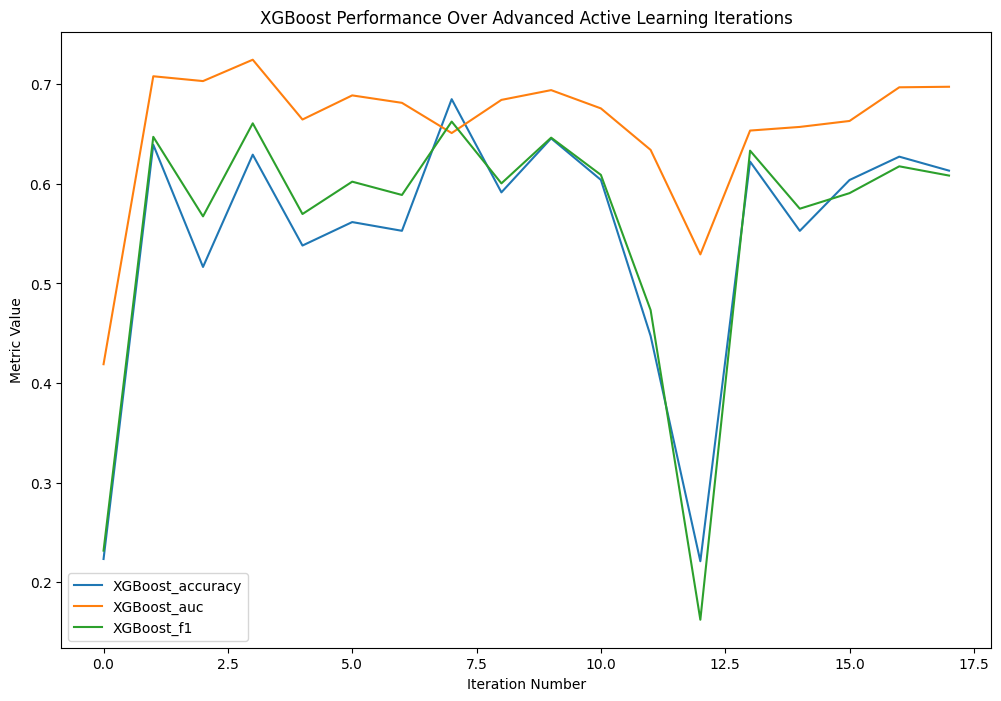

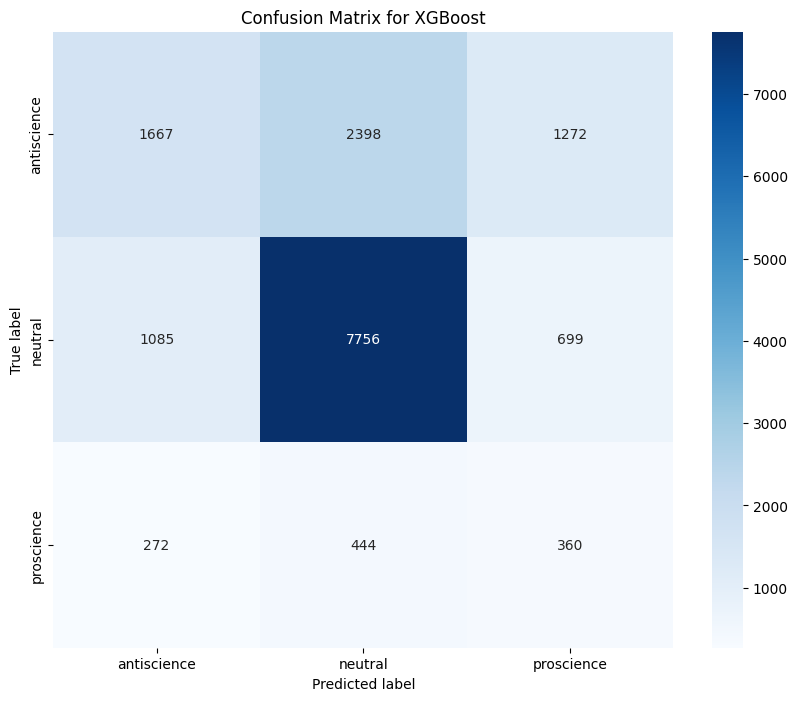

              precision    recall  f1-score   support

 antiscience       0.55      0.31      0.40      5337
     neutral       0.73      0.81      0.77      9540
  proscience       0.15      0.33      0.21      1076

    accuracy                           0.61     15953
   macro avg       0.48      0.49      0.46     15953
weighted avg       0.63      0.61      0.61     15953



In [8]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, f1_score
from modAL.models import ActiveLearner
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from imblearn.over_sampling import SMOTE
from tqdm.notebook import tqdm
import logging
from typing import List, Tuple, Dict
import time
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

class AdvancedXGBoostActiveLearningPipeline:
    def __init__(self, data_file: str, embedding_column: str, label_column: str, 
                 test_size: float = 0.2, initial_labeled_ratio: float = 0.3, random_state: int = 42):
        self.data_file = data_file
        self.embedding_column = embedding_column
        self.label_column = label_column
        self.test_size = test_size
        self.initial_labeled_ratio = initial_labeled_ratio
        self.random_state = random_state
        self.le = LabelEncoder()
        
        self._log_init_info()
        
    def _log_init_info(self) -> None:
        logger.info("Initializing AdvancedXGBoostActiveLearningPipeline")
        logger.info(f"Data file: {self.data_file}")
        logger.info(f"Embedding column: {self.embedding_column}")
        logger.info(f"Label column: {self.label_column}")
        logger.info(f"Test size: {self.test_size}")
        logger.info(f"Initial labeled ratio: {self.initial_labeled_ratio}")
        logger.info(f"Random state: {self.random_state}")

    def load_and_preprocess_data(self) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        logger.info("Loading and preprocessing data")
        start_time = time.time()
        
        chunks = pd.read_csv(self.data_file, chunksize=10000)
        data_list = []
        for chunk in chunks:
            chunk[self.embedding_column] = chunk[self.embedding_column].apply(lambda x: np.fromstring(x.strip('[]'), sep=' '))
            data_list.append(chunk)
        data = pd.concat(data_list)
        
        self.le.fit(data[self.label_column])
        data['encoded_label'] = self.le.transform(data[self.label_column])
        
        X = np.stack(data[self.embedding_column].values)
        y = data['encoded_label'].values
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=self.test_size, random_state=self.random_state, stratify=y)
        
        # Apply SMOTE only to the training data
        smote = SMOTE(random_state=self.random_state)
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
        
        X_initial, X_pool, y_initial, y_pool = train_test_split(
            X_train_resampled, y_train_resampled, train_size=self.initial_labeled_ratio, 
            random_state=self.random_state, stratify=y_train_resampled
        )
        
        end_time = time.time()
        logger.info(f"Data loaded and preprocessed in {end_time - start_time:.2f} seconds")
        logger.info(f"Original data shape: {X.shape}")
        logger.info(f"Resampled training data shape: {X_train_resampled.shape}")
        logger.info(f"Initial labeled set shape: {X_initial.shape}")
        logger.info(f"Pool set shape: {X_pool.shape}")
        logger.info(f"Test data shape: {X_test.shape}")
        logger.info(f"Encoded labels: {self.le.classes_}")
        logger.info(f"Class distribution in resampled training set: {np.bincount(y_train_resampled)}")
        logger.info(f"Class distribution in test set: {np.bincount(y_test)}")
        
        return X_initial, y_initial, X_pool, y_pool, X_test, y_test

    def uncertainty_diversity_sampling(self, classifier: XGBClassifier, X_pool: np.ndarray, n_instances: int) -> List[int]:
        probas = classifier.predict_proba(X_pool)
        uncertainties = 1 - np.max(probas, axis=1)
        uncertain_indices = np.argsort(uncertainties)[-2*n_instances:]
        X_uncertain = X_pool[uncertain_indices]
        
        nn = NearestNeighbors(n_neighbors=min(len(X_uncertain), n_instances), metric='cosine', n_jobs=-1)
        nn.fit(X_uncertain)
        _, indices = nn.kneighbors(X_uncertain[0].reshape(1, -1))
        diverse_indices = indices[0]
        
        return uncertain_indices[diverse_indices]

    def class_balanced_batch_sampling(self, classifier: XGBClassifier, X_pool: np.ndarray, y_pool: np.ndarray, n_instances: int) -> List[int]:
        class_counts = Counter(y_pool)
        n_classes = len(class_counts)
        n_per_class = max(1, n_instances // n_classes)
        
        selected_indices = []
        for class_label in class_counts:
            class_indices = np.where(y_pool == class_label)[0]
            if len(class_indices) < n_per_class:
                selected_indices.extend(class_indices)
            else:
                class_X_pool = X_pool[class_indices]
                class_selected = self.uncertainty_diversity_sampling(classifier, class_X_pool, n_per_class)
                selected_indices.extend(class_indices[class_selected])
        
        if len(selected_indices) < n_instances:
            majority_class = max(class_counts, key=class_counts.get)
            majority_indices = np.where(y_pool == majority_class)[0]
            additional_samples = n_instances - len(selected_indices)
            additional_indices = self.uncertainty_diversity_sampling(classifier, X_pool[majority_indices], additional_samples)
            selected_indices.extend(majority_indices[additional_indices])
        
        return selected_indices[:n_instances]

    def train_with_advanced_active_learning(self, X_initial: np.ndarray, y_initial: np.ndarray, 
                                            X_pool: np.ndarray, y_pool: np.ndarray, X_test: np.ndarray, y_test: np.ndarray, 
                                            n_queries: int = 50, n_instances_per_query: int = 100) -> Tuple[str, List[float], List[float], np.ndarray]:
        logger.info("Starting advanced active learning with XGBoost")
        start_time = time.time()

        xgb_model = XGBClassifier(
            objective='multi:softprob',
            num_class=len(self.le.classes_),
            random_state=self.random_state,
            n_jobs=-1,
            learning_rate=0.1,
            n_estimators=100,
            max_depth=6,
            min_child_weight=1,
            gamma=0,
            subsample=0.8,
            colsample_bytree=0.8
        )

        learner = ActiveLearner(
            estimator=xgb_model,
            X_training=X_initial,
            y_training=y_initial,
            query_strategy=self.class_balanced_batch_sampling
        )

        performance_history = []
        auc_history = []
        f1_history = []
        best_f1 = 0
        iterations_without_improvement = 0
        max_iterations_without_improvement = 10

        for iteration in tqdm(range(n_queries), desc="Advanced Active Learning Progress"):
            query_idx = self.class_balanced_batch_sampling(learner.estimator, X_pool, y_pool, n_instances_per_query)
            
            learner.teach(X_pool[query_idx], y_pool[query_idx], only_new=True)
            
            X_pool = np.delete(X_pool, query_idx, axis=0)
            y_pool = np.delete(y_pool, query_idx)
            
            y_pred = learner.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            performance_history.append(accuracy)
            
            y_proba = learner.predict_proba(X_test)
            auc_roc = roc_auc_score(y_test, y_proba, multi_class='ovo', average='macro')
            auc_history.append(auc_roc)

            f1 = f1_score(y_test, y_pred, average='weighted')
            f1_history.append(f1)

            if f1 > best_f1:
                best_f1 = f1
                iterations_without_improvement = 0
                self.best_model = learner
            else:
                iterations_without_improvement += 1

            if (iteration + 1) % 5 == 0:
                logger.info(f"XGBoost - Iteration {iteration + 1}/{n_queries}: Accuracy = {accuracy:.4f}, AUC-ROC = {auc_roc:.4f}, F1 = {f1:.4f}")

            if iterations_without_improvement >= max_iterations_without_improvement:
                logger.info(f"XGBoost - Early stopping at iteration {iteration + 1} due to no improvement")
                break

        end_time = time.time()
        logger.info(f"XGBoost - Advanced active learning completed in {end_time - start_time:.2f} seconds")
        logger.info(f"XGBoost - Final metrics: Accuracy = {performance_history[-1]:.4f}, AUC-ROC = {auc_history[-1]:.4f}, F1 = {f1_history[-1]:.4f}")

        y_pred_final = learner.predict(X_test)
        cm = confusion_matrix(y_test, y_pred_final)
        
        return "XGBoost", performance_history, auc_history, f1_history, cm

    def run_pipeline(self) -> Tuple[Dict[str, List[float]], Dict[str, np.ndarray], str]:
        logger.info("Starting Advanced XGBoost active learning pipeline")
        start_time = time.time()

        X_initial, y_initial, X_pool, y_pool, X_test, y_test = self.load_and_preprocess_data()

        model_name, performance_history, auc_history, f1_history, cm = self.train_with_advanced_active_learning(
            X_initial, y_initial, X_pool, y_pool, X_test, y_test
        )

        self.model_performance = {
            f"{model_name}_accuracy": performance_history,
            f"{model_name}_auc": auc_history,
            f"{model_name}_f1": f1_history
        }
        self.confusion_matrices = {model_name: cm}
        
        end_time = time.time()
        logger.info(f"Advanced XGBoost Active Learning Pipeline completed in {end_time - start_time:.2f} seconds")
        
        logger.info(f"{model_name} - Initial metrics: Accuracy = {performance_history[0]:.4f}, AUC-ROC = {auc_history[0]:.4f}, F1 = {f1_history[0]:.4f}")
        logger.info(f"{model_name} - Final metrics: Accuracy = {performance_history[-1]:.4f}, AUC-ROC = {auc_history[-1]:.4f}, F1 = {f1_history[-1]:.4f}")

        y_pred = self.best_model.predict(X_test)
        class_report = classification_report(y_test, y_pred, target_names=self.le.classes_)
        logger.info("Classification Report:\n" + class_report)

        return self.model_performance, self.confusion_matrices, class_report

    def plot_results(self) -> None:
        plt.figure(figsize=(12, 8))
        for metric, values in self.model_performance.items():
            plt.plot(values, label=metric)
        plt.title('XGBoost Performance Over Advanced Active Learning Iterations')
        plt.xlabel('Iteration Number')
        plt.ylabel('Metric Value')
        plt.legend()
        plt.show()

    def plot_confusion_matrix(self) -> None:
        for model_name, cm in self.confusion_matrices.items():
            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=self.le.classes_, yticklabels=self.le.classes_)
            plt.title(f'Confusion Matrix for {model_name}')
            plt.ylabel('True label')
            plt.xlabel('Predicted label')
            plt.show()

# Example usage
pipeline = AdvancedXGBoostActiveLearningPipeline("sbert_llama_classifications.csv", "dense_embedding", "cleaned_classification")
results, confusion_matrices, class_report = pipeline.run_pipeline()
pipeline.plot_results()
pipeline.plot_confusion_matrix()
print(class_report)

## XGB with SMOTE, highest recall on proscience (0.43)

In [9]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from modAL.models import ActiveLearner
from modAL.uncertainty import entropy_sampling
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import logging
from typing import List, Tuple, Dict
import time
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

class XGBoostActiveLearningPipeline:
    def __init__(self, data_file: str, embedding_column: str, label_column: str, 
                 test_size: float = 0.2, initial_labeled_ratio: float = 0.3, random_state: int = 42):
        self.data_file = data_file
        self.embedding_column = embedding_column
        self.label_column = label_column
        self.test_size = test_size
        self.initial_labeled_ratio = initial_labeled_ratio
        self.random_state = random_state
        self.le = LabelEncoder()
        
        self._log_init_info()
        
    def _log_init_info(self) -> None:
        logger.info("Initializing XGBoostActiveLearningPipeline")
        logger.info(f"Data file: {self.data_file}")
        logger.info(f"Embedding column: {self.embedding_column}")
        logger.info(f"Label column: {self.label_column}")
        logger.info(f"Test size: {self.test_size}")
        logger.info(f"Initial labeled ratio: {self.initial_labeled_ratio}")
        logger.info(f"Random state: {self.random_state}")

    def load_and_preprocess_data(self) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        logger.info("Loading and preprocessing data")
        start_time = time.time()
        
        # Load data in chunks
        chunks = pd.read_csv(self.data_file, chunksize=10000)
        data_list = []
        for chunk in chunks:
            chunk[self.embedding_column] = chunk[self.embedding_column].apply(lambda x: np.fromstring(x.strip('[]'), sep=' '))
            data_list.append(chunk)
        data = pd.concat(data_list)
        
        self.le.fit(data[self.label_column])
        data['encoded_label'] = self.le.transform(data[self.label_column])
        
        X = np.stack(data[self.embedding_column].values)
        y = data['encoded_label'].values
        
        # Split into train and test first
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=self.test_size, random_state=self.random_state, stratify=y)
        
        # Apply SMOTE only to the training data
        smote = SMOTE(random_state=self.random_state)
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
        
        # Split the resampled training data into initial labeled set and pool
        X_initial, X_pool, y_initial, y_pool = train_test_split(
            X_train_resampled, y_train_resampled, train_size=self.initial_labeled_ratio, 
            random_state=self.random_state, stratify=y_train_resampled
        )
        
        end_time = time.time()
        logger.info(f"Data loaded and preprocessed in {end_time - start_time:.2f} seconds")
        logger.info(f"Original data shape: {X.shape}")
        logger.info(f"Resampled training data shape: {X_train_resampled.shape}")
        logger.info(f"Test data shape: {X_test.shape}")
        logger.info(f"Encoded labels: {self.le.classes_}")
        logger.info(f"Class distribution in resampled training set: {np.bincount(y_train_resampled)}")
        logger.info(f"Class distribution in test set: {np.bincount(y_test)}")
        
        return X_initial, y_initial, X_pool, y_pool, X_test, y_test
        
    def train_with_active_learning(self, X_initial: np.ndarray, y_initial: np.ndarray, 
                                   X_pool: np.ndarray, y_pool: np.ndarray, X_test: np.ndarray, y_test: np.ndarray, 
                                   n_queries: int = 50, n_instances_per_query: int = 500) -> Tuple[str, List[float], List[float], np.ndarray]:
        logger.info("Starting active learning with XGBoost")
        start_time = time.time()

        # Initialize XGBoost model
        xgb_model = XGBClassifier(
            objective='multi:softprob',
            num_class=len(self.le.classes_),
            random_state=self.random_state,
            n_jobs=-1,  # Use all available cores
            learning_rate=0.1,
            n_estimators=100,
            max_depth=6,
            min_child_weight=1,
            gamma=0,
            subsample=0.8,
            colsample_bytree=0.8
        )

        # Create active learner
        learner = ActiveLearner(
            estimator=xgb_model,
            X_training=X_initial,
            y_training=y_initial,
            query_strategy=entropy_sampling
        )

        performance_history = []
        auc_history = []  # Track AUC-ROC score
        best_accuracy = 0
        iterations_without_improvement = 0
        max_iterations_without_improvement = 10

        for iteration in tqdm(range(n_queries), desc="Active Learning Progress"):
            query_idx, _ = learner.query(X_pool, n_instances=n_instances_per_query)
            
            learner.teach(X_pool[query_idx], y_pool[query_idx])
            
            X_pool = np.delete(X_pool, query_idx, axis=0)
            y_pool = np.delete(y_pool, query_idx)
            
            y_pred = learner.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            performance_history.append(accuracy)
            
            # Predict probabilities and calculate AUC-ROC score
            y_proba = learner.predict_proba(X_test)
            auc_roc = roc_auc_score(y_test, y_proba, multi_class='ovo', average='macro')
            auc_history.append(auc_roc)

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                iterations_without_improvement = 0
                self.best_model = learner
            else:
                iterations_without_improvement += 1

            if (iteration + 1) % 5 == 0:
                logger.info(f"XGBoost - Iteration {iteration + 1}/{n_queries}: Accuracy = {accuracy:.4f}, AUC-ROC = {auc_roc:.4f}")

            if iterations_without_improvement >= max_iterations_without_improvement:
                logger.info(f"XGBoost - Early stopping at iteration {iteration + 1} due to no improvement")
                break

        end_time = time.time()
        logger.info(f"XGBoost - Active learning completed in {end_time - start_time:.2f} seconds")
        logger.info(f"XGBoost - Final accuracy: {performance_history[-1]:.4f}, Final AUC-ROC: {auc_history[-1]:.4f}")

        y_pred_final = learner.predict(X_test)
        cm = confusion_matrix(y_test, y_pred_final)
        
        return "XGBoost", performance_history, auc_history, cm


    def run_pipeline(self) -> Tuple[Dict[str, List[float]], Dict[str, np.ndarray], str]:
        logger.info("Starting XGBoost active learning pipeline")
        start_time = time.time()

        X_initial, y_initial, X_pool, y_pool, X_test, y_test = self.load_and_preprocess_data()

        model_name, performance_history, cm = self.train_with_active_learning(
            X_initial, y_initial, X_pool, y_pool, X_test, y_test
        )

        self.model_performance = {model_name: performance_history}
        self.confusion_matrices = {model_name: cm}
        
        end_time = time.time()
        logger.info(f"XGBoost Active Learning Pipeline completed in {end_time - start_time:.2f} seconds")
        
        logger.info(f"{model_name} - Initial accuracy: {performance_history[0]:.4f}, Final accuracy: {performance_history[-1]:.4f}")

        # Generate classification report
        y_pred = self.best_model.predict(X_test)
        class_report = classification_report(y_test, y_pred, target_names=self.le.classes_)
        logger.info("Classification Report:\n" + class_report)

        return self.model_performance, self.confusion_matrices, class_report

    def plot_results(self) -> None:
        plt.figure(figsize=(12, 8))
        for model_name, accuracies in self.model_performance.items():
            plt.plot(accuracies, label=model_name)
        plt.title('XGBoost Performance Over Active Learning Iterations')
        plt.xlabel('Iteration Number')
        plt.ylabel('Test Accuracy')
        plt.legend()
        plt.show()

    def plot_confusion_matrix(self) -> None:
        for model_name, cm in self.confusion_matrices.items():
            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=self.le.classes_, yticklabels=self.le.classes_)
            plt.title(f'Confusion Matrix for {model_name}')
            plt.ylabel('True label')
            plt.xlabel('Predicted label')
            plt.show()

# Example usage in a notebook:
pipeline = XGBoostActiveLearningPipeline("sbert_llama_classifications.csv", "dense_embedding", "cleaned_classification")
results, confusion_matrices, class_report = pipeline.run_pipeline()
pipeline.plot_results()
pipeline.plot_confusion_matrix()
print(class_report)

2024-09-22 19:22:04,443 - INFO - Initializing XGBoostActiveLearningPipeline
2024-09-22 19:22:04,444 - INFO - Data file: sbert_llama_classifications.csv
2024-09-22 19:22:04,444 - INFO - Embedding column: dense_embedding
2024-09-22 19:22:04,445 - INFO - Label column: cleaned_classification
2024-09-22 19:22:04,445 - INFO - Test size: 0.2
2024-09-22 19:22:04,446 - INFO - Initial labeled ratio: 0.3
2024-09-22 19:22:04,447 - INFO - Random state: 42
2024-09-22 19:22:04,447 - INFO - Starting XGBoost active learning pipeline
2024-09-22 19:22:04,448 - INFO - Loading and preprocessing data
2024-09-22 19:22:18,880 - INFO - Data loaded and preprocessed in 14.43 seconds
2024-09-22 19:22:18,881 - INFO - Original data shape: (79763, 384)
2024-09-22 19:22:18,882 - INFO - Resampled training data shape: (114480, 384)
2024-09-22 19:22:18,882 - INFO - Test data shape: (15953, 384)
2024-09-22 19:22:18,883 - INFO - Encoded labels: ['antiscience' 'neutral' 'proscience']
2024-09-22 19:22:18,885 - INFO - Class 

Active Learning Progress:   0%|          | 0/50 [00:00<?, ?it/s]

2024-09-22 19:24:57,335 - INFO - XGBoost - Iteration 5/50: Accuracy = 0.7628, AUC-ROC = 0.8473
2024-09-22 19:28:05,432 - INFO - XGBoost - Iteration 10/50: Accuracy = 0.7647, AUC-ROC = 0.8475
2024-09-22 19:31:18,487 - INFO - XGBoost - Iteration 15/50: Accuracy = 0.7654, AUC-ROC = 0.8485
2024-09-22 19:34:50,013 - INFO - XGBoost - Iteration 20/50: Accuracy = 0.7684, AUC-ROC = 0.8479


KeyboardInterrupt: 

## XGB with Distance. Lower than SMOTE -- but what i try smote with distance?

In [27]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score
from imblearn.over_sampling import SMOTE, BorderlineSMOTE
import logging
import time
import matplotlib.pyplot as plt
import seaborn as sns

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

class ComparativeXGBoostPipeline:
    def __init__(self, data_file: str, embedding_column: str, label_column: str, 
                 test_size: float = 0.2, random_state: int = 42):
        self.data_file = data_file
        self.embedding_column = embedding_column
        self.label_column = label_column
        self.test_size = test_size
        self.random_state = random_state
        self.le = LabelEncoder()
        self.scaler = StandardScaler()
        
        self._log_init_info()
        self._load_and_preprocess_data()
        
    def _log_init_info(self) -> None:
        logger.info("Initializing ComparativeXGBoostPipeline")
        logger.info(f"Data file: {self.data_file}")
        logger.info(f"Embedding column: {self.embedding_column}")
        logger.info(f"Label column: {self.label_column}")
        logger.info(f"Test size: {self.test_size}")
        logger.info(f"Random state: {self.random_state}")

    def _load_and_preprocess_data(self) -> None:
        start_time = time.time()
        logger.info("Loading and preprocessing data...")
        self.data = pd.read_csv(self.data_file)
        
        # Convert embeddings to numpy arrays
        self.data[self.embedding_column] = self.data[self.embedding_column].apply(lambda x: np.fromstring(x.strip('[]'), sep=' '))
        
        # Identify distance columns
        self.distance_columns = [col for col in self.data.columns if col.startswith('distance_to_')]
        logger.info(f"Distance columns found: {self.distance_columns}")
        
        # Scale distance features
        self.data[self.distance_columns] = self.scaler.fit_transform(self.data[self.distance_columns])
        
        self.le.fit(self.data[self.label_column])
        self.data['encoded_label'] = self.le.transform(self.data[self.label_column])
        
        end_time = time.time()
        logger.info(f"Data loaded and preprocessed in {end_time - start_time:.2f} seconds")
        logger.info(f"Data shape: {self.data.shape}")
        logger.info(f"Encoded labels: {self.le.classes_}")

    def prepare_data(self):
        logger.info("Preparing data for training")
        
        # Combine embedding and distance features
        X_embeddings = np.stack(self.data[self.embedding_column].values)
        X_distances = self.data[self.distance_columns].values
        X = np.hstack([X_embeddings, X_distances])
        y = self.data['encoded_label'].values
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=self.test_size, random_state=self.random_state, stratify=y)
        
        logger.info(f"Training set shape: {X_train.shape}")
        logger.info(f"Test set shape: {X_test.shape}")
        
        return X_train, X_test, y_train, y_test

    def train_and_evaluate(self, X_train, X_test, y_train, y_test, method='normal', class_weights=None):
        logger.info(f"Training XGBoost model with {method} method...")
        start_time = time.time()
        
        if method == 'smote':
            smote = SMOTE(random_state=self.random_state)
            X_train, y_train = smote.fit_resample(X_train, y_train)
        elif method == 'borderline_smote':
            bsmote = BorderlineSMOTE(random_state=self.random_state)
            X_train, y_train = bsmote.fit_resample(X_train, y_train)
        
        model = XGBClassifier(
            objective='multi:softprob', 
            num_class=len(self.le.classes_), 
            random_state=self.random_state,
            eval_metric='mlogloss'
        )
        
        if class_weights is not None:
            sample_weights = np.array([class_weights[y] for y in y_train])
            model.fit(X_train, y_train, sample_weight=sample_weights)
        else:
            model.fit(X_train, y_train)
        
        train_time = time.time() - start_time
        logger.info(f"Model trained in {train_time:.2f} seconds")
        
        logger.info("Evaluating model...")
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)
        
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='macro')
        auc_roc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
        cm = confusion_matrix(y_test, y_pred)
        
        logger.info(f"Test Accuracy: {accuracy:.4f}")
        logger.info(f"Macro F1 Score: {f1:.4f}")
        logger.info(f"AUC-ROC Score: {auc_roc:.4f}")
        logger.info("\nClassification Report:")
        logger.info(classification_report(y_test, y_pred, target_names=self.le.classes_))
        
        return {
            'method': method,
            'accuracy': accuracy,
            'f1_score': f1,
            'auc_roc': auc_roc,
            'confusion_matrix': cm,
            'classification_report': classification_report(y_test, y_pred, target_names=self.le.classes_),
            'model': model
        }

    def plot_confusion_matrix(self, cm, method):
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=self.le.classes_, yticklabels=self.le.classes_)
        plt.title(f'Confusion Matrix - {method}')
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.tight_layout()
        plt.savefig(f'confusion_matrix_{method}.png')
        logger.info(f"Confusion matrix saved as 'confusion_matrix_{method}.png'")
        plt.close()

    def plot_feature_importance(self, model, method):
        feature_importance = model.feature_importances_
        feature_names = [f"Emb_{i}" for i in range(len(self.data[self.embedding_column].iloc[0]))] + self.distance_columns
        feature_importance_dict = dict(zip(feature_names, feature_importance))
        sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)
        top_n = 20  # Show top 20 features

        plt.figure(figsize=(12, 8))
        plt.barh([x[0] for x in sorted_features[:top_n]], [x[1] for x in sorted_features[:top_n]])
        plt.xlabel("Feature Importance")
        plt.title(f"Top 20 Most Important Features - {method}")
        plt.tight_layout()
        plt.savefig(f'feature_importance_{method}.png')
        logger.info(f"Feature importance plot saved as 'feature_importance_{method}.png'")
        plt.close()

    def run_pipeline(self):
        logger.info("Starting ComparativeXGBoostPipeline")
        start_time = time.time()
        
        X_train, X_test, y_train, y_test = self.prepare_data()
        
        # Calculate class weights for weighted approach
        class_weights = len(y_train) / (len(np.unique(y_train)) * np.bincount(y_train))
        class_weights = dict(enumerate(class_weights))
        
        methods = [
            ('normal', None),
            ('weighted', class_weights),
            ('smote', None),
            ('borderline_smote', None)
        ]
        
        results = []
        for method, weights in methods:
            result = self.train_and_evaluate(X_train, X_test, y_train, y_test, method, weights)
            results.append(result)
            self.plot_confusion_matrix(result['confusion_matrix'], method)
            self.plot_feature_importance(result['model'], method)
        
        # Compare results
        comparison_df = pd.DataFrame([
            {
                'Method': r['method'],
                'Accuracy': r['accuracy'],
                'F1 Score': r['f1_score'],
                'AUC-ROC': r['auc_roc']
            } for r in results
        ])
        
        logger.info("\nComparison of methods:")
        logger.info(comparison_df.to_string(index=False))
        
        # Save comparison to CSV
        comparison_df.to_csv('method_comparison.csv', index=False)
        logger.info("Comparison saved to 'method_comparison.csv'")
        
        end_time = time.time()
        logger.info(f"Pipeline completed in {end_time - start_time:.2f} seconds")

# Usage
data_file = 'sbert_data_with_distance_features.csv'

comparative_pipeline = ComparativeXGBoostPipeline(data_file, "dense_embedding", "cleaned_classification")
comparative_pipeline.run_pipeline()

2024-09-23 15:33:52,825 - INFO - Initializing ComparativeXGBoostPipeline
2024-09-23 15:33:52,830 - INFO - Data file: sbert_data_with_distance_features.csv
2024-09-23 15:33:52,830 - INFO - Embedding column: dense_embedding
2024-09-23 15:33:52,831 - INFO - Label column: cleaned_classification
2024-09-23 15:33:52,834 - INFO - Test size: 0.2
2024-09-23 15:33:52,836 - INFO - Random state: 42
2024-09-23 15:33:52,837 - INFO - Loading and preprocessing data...
2024-09-23 15:34:05,132 - INFO - Distance columns found: ['distance_to_antiscience', 'distance_to_neutral', 'distance_to_proscience']
2024-09-23 15:34:05,202 - INFO - Data loaded and preprocessed in 12.36 seconds
2024-09-23 15:34:05,203 - INFO - Data shape: (79763, 13)
2024-09-23 15:34:05,206 - INFO - Encoded labels: ['antiscience' 'neutral' 'proscience']
2024-09-23 15:34:05,207 - INFO - Starting ComparativeXGBoostPipeline
2024-09-23 15:34:05,207 - INFO - Preparing data for training
2024-09-23 15:34:05,597 - INFO - Training set shape: (6

## XGB WITH Augmented Data -> should try with also focal loss?

In [30]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, BorderlineSMOTE
import logging
import time
import matplotlib.pyplot as plt
import seaborn as sns

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

class ComparativeXGBoostPipeline:
    def __init__(self, data_file: str, augmented_data_file: str, embedding_column: str, label_column: str, 
                 test_size: float = 0.2, random_state: int = 42):
        self.data_file = data_file
        self.augmented_data_file = augmented_data_file
        self.embedding_column = embedding_column
        self.label_column = label_column
        self.test_size = test_size
        self.random_state = random_state
        self.le = LabelEncoder()
        
        self._log_init_info()
        self._load_and_preprocess_data()
        
    def _log_init_info(self) -> None:
        logger.info("Initializing ComparativeXGBoostPipeline")
        logger.info(f"Main data file: {self.data_file}")
        logger.info(f"Augmented data file: {self.augmented_data_file}")
        logger.info(f"Embedding column: {self.embedding_column}")
        logger.info(f"Label column: {self.label_column}")
        logger.info(f"Test size: {self.test_size}")
        logger.info(f"Random state: {self.random_state}")

    def _process_embeddings(self, df, separator):
        df[self.embedding_column] = df[self.embedding_column].apply(lambda x: np.fromstring(x.strip('[]'), sep=separator))
        return df

    def _load_and_preprocess_data(self) -> None:
        start_time = time.time()
        logger.info("Loading and preprocessing data...")
        
        # Load main data
        self.main_data = pd.read_csv(self.data_file)
        self.main_data = self._process_embeddings(self.main_data, ' ')  # Use space as separator for main data
        logger.info(f"Main data shape: {self.main_data.shape}")
        
        # Load augmented data
        self.augmented_data = pd.read_csv(self.augmented_data_file)
        self.augmented_data = self._process_embeddings(self.augmented_data, ',')  # Use comma as separator for augmented data
        logger.info(f"Augmented data shape: {self.augmented_data.shape}")
        
        # Encode labels for both datasets
        all_labels = pd.concat([self.main_data[self.label_column], self.augmented_data[self.label_column]])
        self.le.fit(all_labels)
        self.main_data['encoded_label'] = self.le.transform(self.main_data[self.label_column])
        self.augmented_data['encoded_label'] = self.le.transform(self.augmented_data[self.label_column])
        
        end_time = time.time()
        logger.info(f"Data loaded and preprocessed in {end_time - start_time:.2f} seconds")
        logger.info(f"Encoded labels: {self.le.classes_}")

    def prepare_data(self):
        logger.info("Preparing data for training")
        
        # Split main data into train and test sets
        X_main = np.stack(self.main_data[self.embedding_column].values)
        y_main = self.main_data['encoded_label'].values
        
        X_train, X_test, y_train, y_test = train_test_split(X_main, y_main, test_size=self.test_size, random_state=self.random_state, stratify=y_main)
        
        # Add augmented data to training set
        X_aug = np.stack(self.augmented_data[self.embedding_column].values)
        y_aug = self.augmented_data['encoded_label'].values
        
        X_train = np.vstack([X_train, X_aug])
        y_train = np.concatenate([y_train, y_aug])
        
        logger.info(f"Training set shape: {X_train.shape}")
        logger.info(f"Test set shape: {X_test.shape}")
        
        return X_train, X_test, y_train, y_test

    def train_and_evaluate(self, X_train, X_test, y_train, y_test, method='normal', class_weights=None):
        logger.info(f"Training XGBoost model with {method} method...")
        start_time = time.time()
        
        if method == 'smote':
            smote = SMOTE(random_state=self.random_state)
            X_train, y_train = smote.fit_resample(X_train, y_train)
        elif method == 'borderline_smote':
            bsmote = BorderlineSMOTE(random_state=self.random_state)
            X_train, y_train = bsmote.fit_resample(X_train, y_train)
        
        model = XGBClassifier(
            objective='multi:softprob', 
            num_class=len(self.le.classes_), 
            random_state=self.random_state,
            eval_metric='mlogloss'
        )
        
        if class_weights is not None:
            sample_weights = np.array([class_weights[y] for y in y_train])
            model.fit(X_train, y_train, sample_weight=sample_weights)
        else:
            model.fit(X_train, y_train)
        
        train_time = time.time() - start_time
        logger.info(f"Model trained in {train_time:.2f} seconds")
        
        logger.info("Evaluating model...")
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)
        
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='macro')
        auc_roc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
        cm = confusion_matrix(y_test, y_pred)
        
        logger.info(f"Test Accuracy: {accuracy:.4f}")
        logger.info(f"Macro F1 Score: {f1:.4f}")
        logger.info(f"AUC-ROC Score: {auc_roc:.4f}")
        logger.info("\nClassification Report:")
        logger.info(classification_report(y_test, y_pred, target_names=self.le.classes_))
        
        return {
            'method': method,
            'accuracy': accuracy,
            'f1_score': f1,
            'auc_roc': auc_roc,
            'confusion_matrix': cm,
            'classification_report': classification_report(y_test, y_pred, target_names=self.le.classes_),
            'model': model
        }

    def plot_confusion_matrix(self, cm, method):
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=self.le.classes_, yticklabels=self.le.classes_)
        plt.title(f'Confusion Matrix - {method}')
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.tight_layout()
        plt.savefig(f'confusion_matrix_{method}.png')
        logger.info(f"Confusion matrix saved as 'confusion_matrix_{method}.png'")
        plt.close()

    def plot_feature_importance(self, model, method):
        feature_importance = model.feature_importances_
        feature_names = [f"Emb_{i}" for i in range(len(self.main_data[self.embedding_column].iloc[0]))]
        feature_importance_dict = dict(zip(feature_names, feature_importance))
        sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)
        top_n = 20  # Show top 20 features

        plt.figure(figsize=(12, 8))
        plt.barh([x[0] for x in sorted_features[:top_n]], [x[1] for x in sorted_features[:top_n]])
        plt.xlabel("Feature Importance")
        plt.title(f"Top 20 Most Important Features - {method}")
        plt.tight_layout()
        plt.savefig(f'feature_importance_{method}.png')
        logger.info(f"Feature importance plot saved as 'feature_importance_{method}.png'")
        plt.close()

    def run_pipeline(self):
        logger.info("Starting ComparativeXGBoostPipeline")
        start_time = time.time()
        
        X_train, X_test, y_train, y_test = self.prepare_data()
        
        # Calculate class weights for weighted approach
        class_weights = len(y_train) / (len(np.unique(y_train)) * np.bincount(y_train))
        class_weights = dict(enumerate(class_weights))
        
        methods = [
            ('normal', None),
            ('weighted', class_weights),
            ('smote', None),
            ('borderline_smote', None)
        ]
        
        results = []
        for method, weights in methods:
            result = self.train_and_evaluate(X_train, X_test, y_train, y_test, method, weights)
            results.append(result)
            self.plot_confusion_matrix(result['confusion_matrix'], method)
            self.plot_feature_importance(result['model'], method)
        
        # Compare results
        comparison_df = pd.DataFrame([
            {
                'Method': r['method'],
                'Accuracy': r['accuracy'],
                'F1 Score': r['f1_score'],
                'AUC-ROC': r['auc_roc']
            } for r in results
        ])
        
        logger.info("\nComparison of methods:")
        logger.info(comparison_df.to_string(index=False))
        
        # Save comparison to CSV
        comparison_df.to_csv('method_comparison.csv', index=False)
        logger.info("Comparison saved to 'method_comparison.csv'")
        
        end_time = time.time()
        logger.info(f"Pipeline completed in {end_time - start_time:.2f} seconds")

# Usage
main_data_file = 'sbert_data_with_distance_features.csv'
augmented_data_file = 'cleaned_proscience_da.csv'

comparative_pipeline = ComparativeXGBoostPipeline(main_data_file, augmented_data_file, "dense_embedding", "cleaned_classification")
comparative_pipeline.run_pipeline()

2024-09-23 15:59:09,196 - INFO - Initializing ComparativeXGBoostPipeline
2024-09-23 15:59:09,197 - INFO - Main data file: sbert_data_with_distance_features.csv
2024-09-23 15:59:09,197 - INFO - Augmented data file: cleaned_proscience_da.csv
2024-09-23 15:59:09,198 - INFO - Embedding column: dense_embedding
2024-09-23 15:59:09,199 - INFO - Label column: cleaned_classification
2024-09-23 15:59:09,199 - INFO - Test size: 0.2
2024-09-23 15:59:09,200 - INFO - Random state: 42
2024-09-23 15:59:09,201 - INFO - Loading and preprocessing data...
2024-09-23 15:59:20,847 - INFO - Main data shape: (79763, 13)
2024-09-23 15:59:21,810 - INFO - Augmented data shape: (5378, 4)
2024-09-23 15:59:21,820 - INFO - Data loaded and preprocessed in 12.62 seconds
2024-09-23 15:59:21,821 - INFO - Encoded labels: ['antiscience' 'neutral' 'proscience']
2024-09-23 15:59:21,821 - INFO - Starting ComparativeXGBoostPipeline
2024-09-23 15:59:21,821 - INFO - Preparing data for training
2024-09-23 15:59:22,762 - INFO - T

## CATBOOST WITH AUGEMENTED DATA

In [10]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier, Pool
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, BorderlineSMOTE
import logging
import time
import matplotlib.pyplot as plt
import seaborn as sns

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

class ComparativeCatBoostPipeline:
    def __init__(self, data_file: str, augmented_data_file: str, embedding_column: str, label_column: str, 
                 test_size: float = 0.2, random_state: int = 42):
        self.data_file = data_file
        self.augmented_data_file = augmented_data_file
        self.embedding_column = embedding_column
        self.label_column = label_column
        self.test_size = test_size
        self.random_state = random_state
        self.le = LabelEncoder()
        
        self._log_init_info()
        self._load_and_preprocess_data()
        
    def _log_init_info(self) -> None:
        logger.info("Initializing ComparativeCatBoostPipeline")
        logger.info(f"Main data file: {self.data_file}")
        logger.info(f"Augmented data file: {self.augmented_data_file}")
        logger.info(f"Embedding column: {self.embedding_column}")
        logger.info(f"Label column: {self.label_column}")
        logger.info(f"Test size: {self.test_size}")
        logger.info(f"Random state: {self.random_state}")

    def _process_embeddings(self, df, separator):
        df[self.embedding_column] = df[self.embedding_column].apply(lambda x: np.fromstring(x.strip('[]'), sep=separator))
        return df

    def _load_and_preprocess_data(self) -> None:
        start_time = time.time()
        logger.info("Loading and preprocessing data...")
        
        # Load main data
        self.main_data = pd.read_csv(self.data_file)
        self.main_data = self._process_embeddings(self.main_data, ' ')
        logger.info(f"Main data shape: {self.main_data.shape}")
        
        # Load augmented data
        self.augmented_data = pd.read_csv(self.augmented_data_file)
        self.augmented_data = self._process_embeddings(self.augmented_data, ',')
        logger.info(f"Augmented data shape: {self.augmented_data.shape}")
        
        # Encode labels for both datasets
        all_labels = pd.concat([self.main_data[self.label_column], self.augmented_data[self.label_column]])
        self.le.fit(all_labels)
        self.main_data['encoded_label'] = self.le.transform(self.main_data[self.label_column])
        self.augmented_data['encoded_label'] = self.le.transform(self.augmented_data[self.label_column])
        
        end_time = time.time()
        logger.info(f"Data loaded and preprocessed in {end_time - start_time:.2f} seconds")
        logger.info(f"Encoded labels: {self.le.classes_}")

    def prepare_data(self):
        logger.info("Preparing data for training")
        
        # Split main data into train and test sets
        X_main = np.stack(self.main_data[self.embedding_column].values)
        y_main = self.main_data['encoded_label'].values
        
        X_train, X_test, y_train, y_test = train_test_split(X_main, y_main, test_size=self.test_size, random_state=self.random_state, stratify=y_main)
        
        # Add augmented data to training set
        X_aug = np.stack(self.augmented_data[self.embedding_column].values)
        y_aug = self.augmented_data['encoded_label'].values
        
        X_train = np.vstack([X_train, X_aug])
        y_train = np.concatenate([y_train, y_aug])
        
        logger.info(f"Training set shape: {X_train.shape}")
        logger.info(f"Test set shape: {X_test.shape}")
        
        return X_train, X_test, y_train, y_test

    def train_and_evaluate(self, X_train, X_test, y_train, y_test, method='weighted', class_weights=None):
        logger.info(f"Training CatBoost model with {method} method...")
        start_time = time.time()
        
        if method == 'smote':
            smote = SMOTE(random_state=self.random_state)
            X_train, y_train = smote.fit_resample(X_train, y_train)
        elif method == 'borderline_smote':
            bsmote = BorderlineSMOTE(random_state=self.random_state)
            X_train, y_train = bsmote.fit_resample(X_train, y_train)
        
        # Convert class_weights dict to sample weights array
        if class_weights is not None:
            sample_weights = np.array([class_weights[y] for y in y_train])
        else:
            sample_weights = None

        # Create CatBoost Pool objects
        train_pool = Pool(X_train, y_train, weight=sample_weights)
        test_pool = Pool(X_test, y_test)
        
        model = CatBoostClassifier(
            iterations=1000,
            learning_rate=0.1,
            depth=6,
            loss_function='MultiClass',
            random_seed=self.random_state,
            eval_metric='MultiClass',
            auto_class_weights='Balanced',  # Let CatBoost handle class weights automatically
            verbose=100
        )
        
        model.fit(train_pool, eval_set=test_pool, early_stopping_rounds=50, verbose=False)
        
        train_time = time.time() - start_time
        logger.info(f"Model trained in {train_time:.2f} seconds")
        
        logger.info("Evaluating model...")
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)
        
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='macro')
        auc_roc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
        cm = confusion_matrix(y_test, y_pred)
        
        logger.info(f"Test Accuracy: {accuracy:.4f}")
        logger.info(f"Macro F1 Score: {f1:.4f}")
        logger.info(f"AUC-ROC Score: {auc_roc:.4f}")
        logger.info("\nClassification Report:")
        logger.info(classification_report(y_test, y_pred, target_names=self.le.classes_))
        
        return {
            'method': method,
            'accuracy': accuracy,
            'f1_score': f1,
            'auc_roc': auc_roc,
            'confusion_matrix': cm,
            'classification_report': classification_report(y_test, y_pred, target_names=self.le.classes_),
            'model': model
        }

    def plot_confusion_matrix(self, cm, method):
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=self.le.classes_, yticklabels=self.le.classes_)
        plt.title(f'Confusion Matrix - {method}')
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.tight_layout()
        plt.savefig(f'confusion_matrix_{method}.png')
        logger.info(f"Confusion matrix saved as 'confusion_matrix_{method}.png'")
        plt.close()

    def plot_feature_importance(self, model, method):
        feature_importance = model.get_feature_importance()
        feature_names = [f"Emb_{i}" for i in range(len(self.main_data[self.embedding_column].iloc[0]))]
        feature_importance_dict = dict(zip(feature_names, feature_importance))
        sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)
        top_n = 20  # Show top 20 features

        plt.figure(figsize=(12, 8))
        plt.barh([x[0] for x in sorted_features[:top_n]], [x[1] for x in sorted_features[:top_n]])
        plt.xlabel("Feature Importance")
        plt.title(f"Top 20 Most Important Features - {method}")
        plt.tight_layout()
        plt.savefig(f'feature_importance_{method}.png')
        logger.info(f"Feature importance plot saved as 'feature_importance_{method}.png'")
        plt.close()

    def run_pipeline(self):
        logger.info("Starting ComparativeCatBoostPipeline")
        start_time = time.time()
        
        X_train, X_test, y_train, y_test = self.prepare_data()
        
        # Calculate class weights for weighted approach
        class_counts = np.bincount(y_train)
        class_weights = {i: len(y_train) / (len(class_counts) * count) for i, count in enumerate(class_counts)}
        
        methods = [
            ('weighted', class_weights),
        ]
        
        results = []
        for method, weights in methods:
            result = self.train_and_evaluate(X_train, X_test, y_train, y_test, method, weights)
            results.append(result)
            self.plot_confusion_matrix(result['confusion_matrix'], method)
            self.plot_feature_importance(result['model'], method)

# Usage
main_data_file = 'sbert_data_with_distance_features.csv'
augmented_data_file = 'cleaned_proscience_da.csv'

comparative_pipeline = ComparativeCatBoostPipeline(main_data_file, augmented_data_file, "dense_embedding", "cleaned_classification")
comparative_pipeline.run_pipeline()

2024-09-25 09:34:06,235 - INFO - Initializing ComparativeCatBoostPipeline
2024-09-25 09:34:06,236 - INFO - Main data file: sbert_data_with_distance_features.csv
2024-09-25 09:34:06,236 - INFO - Augmented data file: cleaned_proscience_da.csv
2024-09-25 09:34:06,237 - INFO - Embedding column: dense_embedding
2024-09-25 09:34:06,237 - INFO - Label column: cleaned_classification
2024-09-25 09:34:06,238 - INFO - Test size: 0.2
2024-09-25 09:34:06,239 - INFO - Random state: 42
2024-09-25 09:34:06,239 - INFO - Loading and preprocessing data...
2024-09-25 09:34:17,176 - INFO - Main data shape: (79763, 13)
2024-09-25 09:34:18,135 - INFO - Augmented data shape: (5378, 4)
2024-09-25 09:34:18,145 - INFO - Data loaded and preprocessed in 11.91 seconds
2024-09-25 09:34:18,145 - INFO - Encoded labels: ['antiscience' 'neutral' 'proscience']
2024-09-25 09:34:18,700 - INFO - Starting ComparativeCatBoostPipeline
2024-09-25 09:34:18,701 - INFO - Preparing data for training
2024-09-25 09:34:19,066 - INFO -

## Light GB with Focal Loss

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from scipy import special
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import Parallel, delayed
import logging
import time

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

### Improved Focal Loss Implementation
class ImprovedFocalLoss:
    def __init__(self, alpha=0.75, gamma=2.0, epsilon=1e-8):
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon  # To prevent numerical instability

    def init_score(self, y):
        pos_frac = np.mean(y)
        return np.log(pos_frac / (1 - pos_frac + self.epsilon))

    def lgb_obj(self, preds, train_data):
        y_true = train_data.get_label()
        preds_prob = special.expit(preds)
        p_t = preds_prob * y_true + (1 - preds_prob) * (1 - y_true)
        
        # Calculate gradient and hessian
        grad = self.alpha * y_true * (1 - p_t)**self.gamma * (self.gamma * p_t * np.log(np.clip(p_t, self.epsilon, 1.0)) + p_t - 1) - \
               (1 - self.alpha) * (1 - y_true) * p_t**self.gamma * (self.gamma * (1 - p_t) * np.log(np.clip(1 - p_t, self.epsilon, 1.0)) - p_t)
        
        hess = self.alpha * y_true * (1 - p_t)**(self.gamma - 1) * (p_t * (2 * self.gamma * (p_t - 1) + p_t + 1) - self.gamma**2 * p_t * (1 - p_t) * np.log(np.clip(p_t, self.epsilon, 1.0))) + \
               (1 - self.alpha) * (1 - y_true) * p_t**(self.gamma - 1) * ((1 - p_t) * (2 * self.gamma * p_t + 1 - p_t) + self.gamma**2 * p_t * (1 - p_t) * np.log(np.clip(1 - p_t, self.epsilon, 1.0)))
        
        return grad, hess

    def lgb_eval(self, preds, train_data):
        y_true = train_data.get_label()
        preds_prob = special.expit(preds)
        p_t = preds_prob * y_true + (1 - preds_prob) * (1 - y_true)
        focal_loss = -self.alpha * y_true * (1 - p_t)**self.gamma * np.log(np.clip(p_t, self.epsilon, 1.0)) - \
                     (1 - self.alpha) * (1 - y_true) * p_t**self.gamma * np.log(np.clip(1 - p_t, self.epsilon, 1.0))
        return 'focal_loss', np.mean(focal_loss), False

### One-vs-Rest with Customized Loss (e.g., Focal Loss)
class OneVsRestLightGBMWithCustomizedLoss:
    def __init__(self, loss, n_jobs=3):
        self.loss = loss
        self.n_jobs = n_jobs

    def fit(self, X, y, **fit_params):
        self.label_binarizer_ = LabelBinarizer(sparse_output=True)
        Y = self.label_binarizer_.fit_transform(y)
        Y = Y.tocsc()
        self.classes_ = self.label_binarizer_.classes_
        columns = (col.toarray().ravel() for col in Y.T)
        self.results_ = Parallel(n_jobs=self.n_jobs)(delayed(self._fit_binary)(X, column, **fit_params)
                                                     for column in columns)
        return self

    def _fit_binary(self, X, y, **fit_params):
        unique_y = np.unique(y)
        init_score_value = self.loss.init_score(y)
        train_data = lgb.Dataset(X, y, init_score=np.full_like(y, init_score_value, dtype=float))
        estimator = lgb.train(params=fit_params, train_set=train_data, fobj=self.loss.lgb_obj, feval=self.loss.lgb_eval, verbose_eval=10)
        return estimator, init_score_value

    def predict(self, X):
        n_samples = X.shape[0]
        maxima = np.full(n_samples, -np.inf, dtype=float)
        argmaxima = np.zeros(n_samples, dtype=int)
        for i, (estimator, init_score) in enumerate(self.results_):
            margins = estimator.predict(X, raw_score=True)
            prob = special.expit(margins + init_score)
            np.maximum(maxima, prob, out=maxima)
            argmaxima[maxima == prob] = i
        return self.label_binarizer_.classes_[argmaxima]

    def predict_proba(self, X):
        y_proba = np.zeros((X.shape[0], len(self.results_)))
        for i, (estimator, init_score) in enumerate(self.results_):
            margins = estimator.predict(X, raw_score=True)
            y_proba[:, i] = special.expit(margins + init_score)
        return y_proba / np.sum(y_proba, axis=1, keepdims=True)

### Weighted LightGBM Classifier for Multiclass
class WeightedLightGBM:
    def __init__(self, n_jobs=3):
        self.n_jobs = n_jobs

    def fit(self, X, y, **fit_params):
        self.le = LabelEncoder()
        y_encoded = self.le.fit_transform(y)
        self.classes_ = self.le.classes_

        class_weights = fit_params.pop('class_weight', None)
        if class_weights is None:
            class_weights = {cls: 1.0 for cls in range(len(self.classes_))}

        sample_weights = np.array([class_weights[cls] for cls in y_encoded])
        self.model = lgb.LGBMClassifier(n_jobs=self.n_jobs, **fit_params)
        self.model.fit(X, y_encoded, sample_weight=sample_weights)
        return self

    def predict(self, X):
        return self.le.inverse_transform(self.model.predict(X))

    def predict_proba(self, X):
        return self.model.predict_proba(X)

### Main Pipeline
class LightGBMPipeline:
    def __init__(self, data_file, augmented_data_file, embedding_column, label_column, test_size=0.2, random_state=42):
        self.data_file = data_file
        self.augmented_data_file = augmented_data_file
        self.embedding_column = embedding_column
        self.label_column = label_column
        self.test_size = test_size
        self.random_state = random_state
        self.le = LabelEncoder()

        self._load_and_preprocess_data()

    def _process_embeddings(self, df, separator):
        df[self.embedding_column] = df[self.embedding_column].apply(lambda x: np.fromstring(x.strip('[]'), sep=separator))
        return df

    def _load_and_preprocess_data(self):
        logger.info("Loading and preprocessing data...")
        self.main_data = pd.read_csv(self.data_file)
        self.main_data = self._process_embeddings(self.main_data, ' ')
        self.augmented_data = pd.read_csv(self.augmented_data_file)
        self.augmented_data = self._process_embeddings(self.augmented_data, ',')

        all_labels = pd.concat([self.main_data[self.label_column], self.augmented_data[self.label_column]])
        self.le.fit(all_labels)
        self.main_data['encoded_label'] = self.le.transform(self.main_data[self.label_column])
        self.augmented_data['encoded_label'] = self.le.transform(self.augmented_data[self.label_column])

    def prepare_data(self):
        logger.info("Preparing data...")
        X_main = np.stack(self.main_data[self.embedding_column].values)
        y_main = self.main_data['encoded_label'].values
        X_train, X_test, y_train, y_test = train_test_split(X_main, y_main, test_size=self.test_size, random_state=self.random_state, stratify=y_main)

        X_aug = np.stack(self.augmented_data[self.embedding_column].values)
        y_aug = self.augmented_data['encoded_label'].values

        X_train = np.vstack([X_train, X_aug])
        y_train = np.concatenate([y_train, y_aug])

        return X_train, X_test, y_train, y_test

    def train_and_evaluate_focal_loss(self, X_train, X_test, y_train, y_test):
        logger.info("Training Focal Loss model...")
        params = {'num_leaves': 31, 'learning_rate': 0.05, 'feature_fraction': 0.9}
        loss = ImprovedFocalLoss(alpha=0.75, gamma=2.0)
        clf = OneVsRestLightGBMWithCustomizedLoss(loss=loss)
        clf.fit(X_train, y_train, **params)
        return self._evaluate_model(X_test, y_test, clf, "Focal Loss")

    def train_and_evaluate_weighted(self, X_train, X_test, y_train, y_test):
        logger.info("Training Weighted LightGBM model...")
        class_weights = {cls: len(y_train) / (len(self.le.classes_) * np.sum(y_train == cls)) for cls in range(len(self.le.classes_))}
        params = {'num_leaves': 31, 'learning_rate': 0.05, 'feature_fraction': 0.9}
        clf = WeightedLightGBM()
        clf.fit(X_train, y_train, class_weight=class_weights, **params)
        return self._evaluate_model(X_test, y_test, clf, "Weighted LightGBM")

    def _evaluate_model(self, X_test, y_test, model, model_name):
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='macro')
        recall = recall_score(y_test, y_pred, average='macro')
        f1 = f1_score(y_test, y_pred, average='macro')
        auc_roc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
        cm = confusion_matrix(y_test, y_pred)

        logger.info(f"{model_name} - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, AUC-ROC: {auc_roc:.4f}")
        return {'model_name': model_name, 'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1, 'auc_roc': auc_roc, 'confusion_matrix': cm}

    def run_pipeline(self):
        X_train, X_test, y_train, y_test = self.prepare_data()
        results = []

        # Train and evaluate Focal Loss model
        focal_loss_result = self.train_and_evaluate_focal_loss(X_train, X_test, y_train, y_test)
        results.append(focal_loss_result)

        # Train and evaluate Weighted LightGBM model
        weighted_result = self.train_and_evaluate_weighted(X_train, X_test, y_train, y_test)
        results.append(weighted_result)

        # Compare results
        comparison_df = pd.DataFrame(results)
        logger.info("\nComparison of methods:")
        logger.info(comparison_df.to_string(index=False))

        # Save comparison to CSV
        comparison_df.to_csv('lightgbm_method_comparison.csv', index=False)
        logger.info("Comparison saved to 'lightgbm_method_comparison.csv'")

# Usage
main_data_file = 'sbert_data_with_distance_features.csv'
augmented_data_file = 'cleaned_proscience_da.csv'

pipeline = LightGBMPipeline(main_data_file, augmented_data_file, "dense_embedding", "cleaned_classification")
pipeline.run_pipeline()


2024-09-24 15:20:02,068 - INFO - Loading and preprocessing data...
2024-09-24 15:20:14,895 - INFO - Preparing data...
2024-09-24 15:20:15,371 - INFO - Training Focal Loss model...
2024-09-24 15:20:25,478 - INFO - Focal Loss - Accuracy: 0.7113, Precision: 0.5323, Recall: 0.4717, F1: 0.4658, AUC-ROC: 0.7420
2024-09-24 15:20:25,479 - INFO - Training Weighted LightGBM model...


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


2024-09-24 15:20:46,878 - INFO - Weighted LightGBM - Accuracy: 0.7291, Precision: 0.6158, Recall: 0.6789, F1: 0.6204, AUC-ROC: 0.8806
2024-09-24 15:20:46,881 - INFO - 
Comparison of methods:
2024-09-24 15:20:46,890 - INFO -        model_name  accuracy  precision   recall       f1  auc_roc                                        confusion_matrix
       Focal Loss  0.711277   0.532273 0.471697 0.465803 0.742034     [[2594, 2718, 25], [772, 8739, 29], [565, 497, 14]]
Weighted LightGBM  0.729142   0.615840 0.678945 0.620394 0.880551 [[3591, 641, 1105], [1175, 7409, 956], [307, 137, 632]]
2024-09-24 15:20:46,898 - INFO - Comparison saved to 'lightgbm_method_comparison.csv'


## XGB with SMOTE Distance 

2024-09-23 10:34:16,709 - INFO - Initializing XGBoostActiveLearningPipeline
2024-09-23 10:34:16,710 - INFO - Data file: sbert_data_with_distance_features.csv
2024-09-23 10:34:16,711 - INFO - Embedding column: dense_embedding
2024-09-23 10:34:16,711 - INFO - Label column: cleaned_classification
2024-09-23 10:34:16,712 - INFO - Distance features: ['distance_to_antiscience', 'distance_to_neutral', 'distance_to_proscience']
2024-09-23 10:34:16,712 - INFO - Test size: 0.2
2024-09-23 10:34:16,713 - INFO - Initial labeled ratio: 0.3
2024-09-23 10:34:16,714 - INFO - Random state: 42
2024-09-23 10:34:16,714 - INFO - Starting XGBoost active learning pipeline
2024-09-23 10:34:16,715 - INFO - Loading and preprocessing data
2024-09-23 10:34:36,460 - INFO - Data loaded and preprocessed in 19.74 seconds
2024-09-23 10:34:36,632 - INFO - Original data shape: (79763, 387)
2024-09-23 10:34:36,657 - INFO - Resampled training data shape: (114480, 387)
2024-09-23 10:34:36,664 - INFO - Test data shape: (1595

Active Learning Progress:   0%|          | 0/50 [00:00<?, ?it/s]

2024-09-23 10:36:51,755 - INFO - XGBoost - Iteration 5/50: Accuracy = 0.7606, AUC-ROC = 0.8482
2024-09-23 10:39:06,638 - INFO - XGBoost - Iteration 10/50: Accuracy = 0.7610, AUC-ROC = 0.8480
2024-09-23 10:42:00,170 - INFO - XGBoost - Iteration 15/50: Accuracy = 0.7654, AUC-ROC = 0.8472
2024-09-23 10:45:10,123 - INFO - XGBoost - Iteration 20/50: Accuracy = 0.7632, AUC-ROC = 0.8476
2024-09-23 10:48:03,857 - INFO - XGBoost - Iteration 25/50: Accuracy = 0.7651, AUC-ROC = 0.8483
2024-09-23 10:51:30,375 - INFO - XGBoost - Iteration 30/50: Accuracy = 0.7689, AUC-ROC = 0.8483
2024-09-23 10:55:08,692 - INFO - XGBoost - Iteration 35/50: Accuracy = 0.7667, AUC-ROC = 0.8498
2024-09-23 10:58:36,121 - INFO - XGBoost - Iteration 40/50: Accuracy = 0.7681, AUC-ROC = 0.8488
2024-09-23 10:59:18,332 - INFO - XGBoost - Early stopping at iteration 41 due to no improvement
2024-09-23 10:59:18,351 - INFO - XGBoost - Active learning completed in 1477.73 seconds
2024-09-23 10:59:18,352 - INFO - XGBoost - Final 

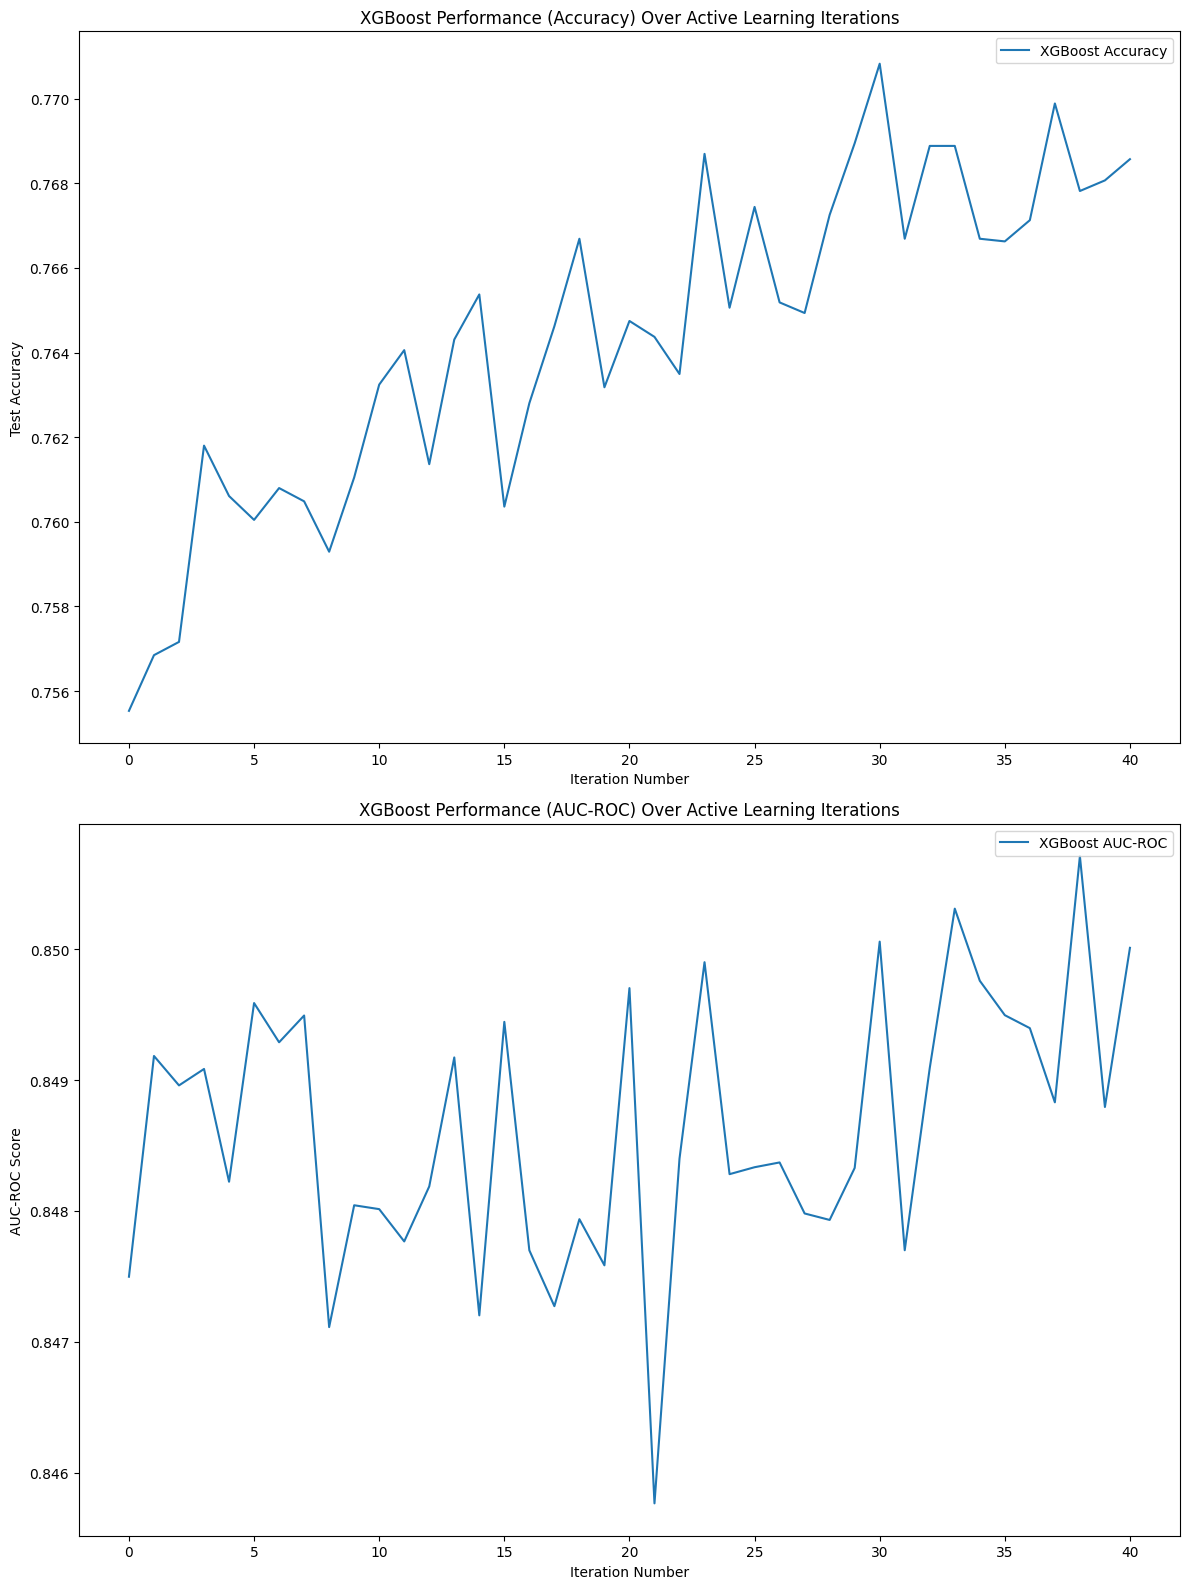

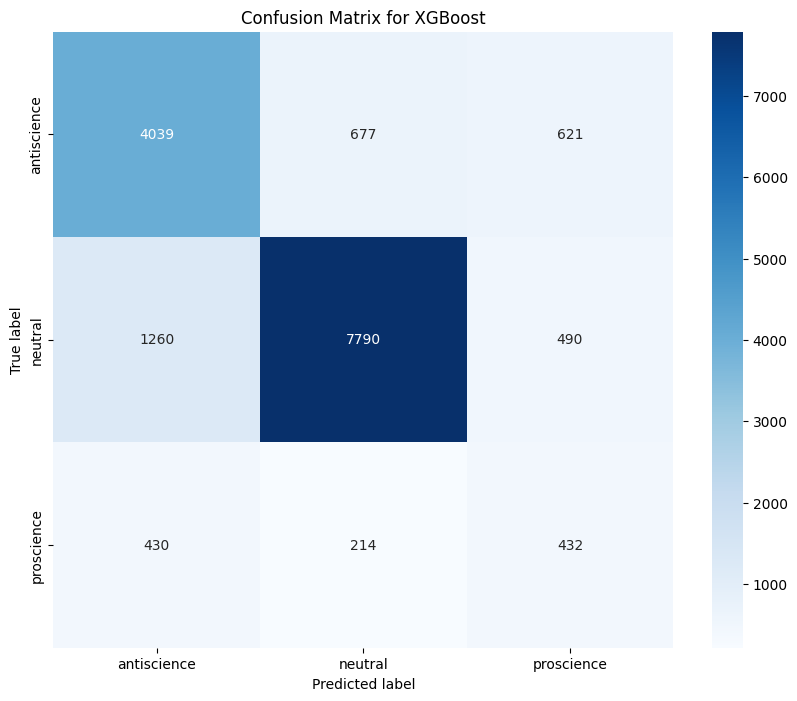

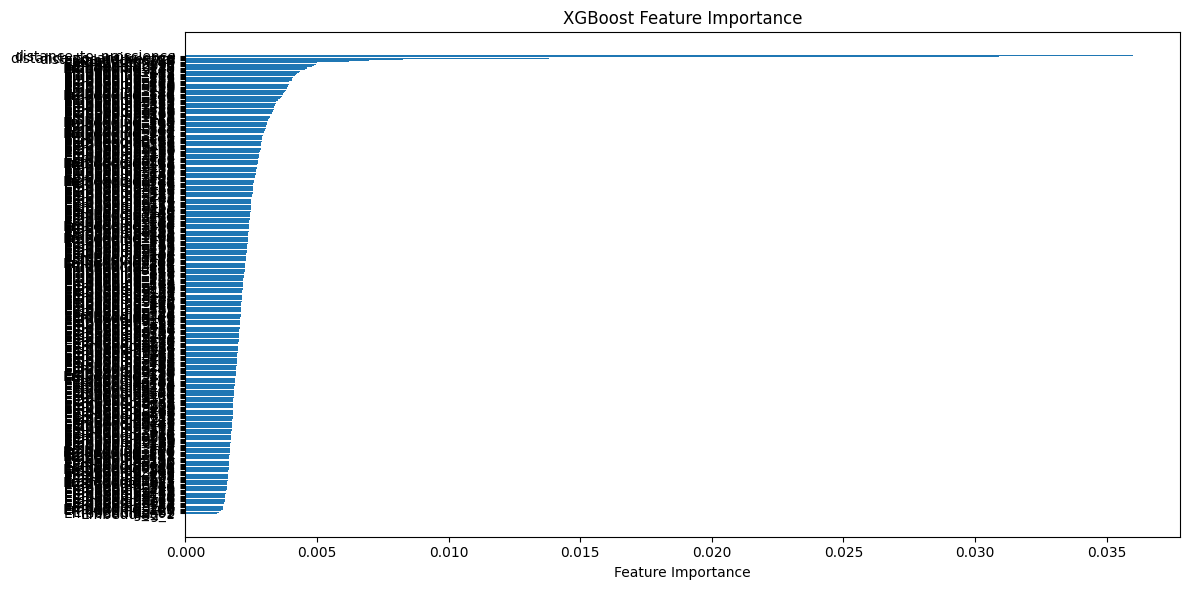

              precision    recall  f1-score   support

 antiscience       0.71      0.76      0.73      5337
     neutral       0.90      0.82      0.86      9540
  proscience       0.28      0.40      0.33      1076

    accuracy                           0.77     15953
   macro avg       0.63      0.66      0.64     15953
weighted avg       0.79      0.77      0.78     15953



In [19]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from modAL.models import ActiveLearner
from modAL.uncertainty import entropy_sampling
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import logging
from typing import List, Tuple, Dict
import time
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

class XGBoostActiveLearningPipeline:
    def __init__(self, data_file: str, embedding_column: str, label_column: str, 
                 distance_features: List[str] = ['distance_to_antiscience', 'distance_to_neutral', 'distance_to_proscience'],
                 test_size: float = 0.2, initial_labeled_ratio: float = 0.3, random_state: int = 42):
        self.data_file = data_file
        self.embedding_column = embedding_column
        self.label_column = label_column
        self.distance_features = distance_features
        self.test_size = test_size
        self.initial_labeled_ratio = initial_labeled_ratio
        self.random_state = random_state
        self.le = LabelEncoder()
        
        self._log_init_info()
        
    def _log_init_info(self) -> None:
        logger.info("Initializing XGBoostActiveLearningPipeline")
        logger.info(f"Data file: {self.data_file}")
        logger.info(f"Embedding column: {self.embedding_column}")
        logger.info(f"Label column: {self.label_column}")
        logger.info(f"Distance features: {self.distance_features}")
        logger.info(f"Test size: {self.test_size}")
        logger.info(f"Initial labeled ratio: {self.initial_labeled_ratio}")
        logger.info(f"Random state: {self.random_state}")

    def load_and_preprocess_data(self) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        logger.info("Loading and preprocessing data")
        start_time = time.time()
        
        # Load data in chunks
        chunks = pd.read_csv(self.data_file, chunksize=10000)
        data_list = []
        for chunk in chunks:
            chunk[self.embedding_column] = chunk[self.embedding_column].apply(lambda x: np.fromstring(x.strip('[]'), sep=' '))
            data_list.append(chunk)
        data = pd.concat(data_list)
        
        self.le.fit(data[self.label_column])
        data['encoded_label'] = self.le.transform(data[self.label_column])
        
        # Combine embedding with distance features
        X_embedding = np.stack(data[self.embedding_column].values)
        X_distance = data[self.distance_features].values
        X = np.hstack((X_embedding, X_distance))
        y = data['encoded_label'].values
        
        # Split into train and test first
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=self.test_size, random_state=self.random_state, stratify=y)
        
        # Apply SMOTE only to the training data
        smote = SMOTE(random_state=self.random_state)
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
        
        # Split the resampled training data into initial labeled set and pool
        X_initial, X_pool, y_initial, y_pool = train_test_split(
            X_train_resampled, y_train_resampled, train_size=self.initial_labeled_ratio, 
            random_state=self.random_state, stratify=y_train_resampled
        )
        
        end_time = time.time()
        logger.info(f"Data loaded and preprocessed in {end_time - start_time:.2f} seconds")
        logger.info(f"Original data shape: {X.shape}")
        logger.info(f"Resampled training data shape: {X_train_resampled.shape}")
        logger.info(f"Test data shape: {X_test.shape}")
        logger.info(f"Encoded labels: {self.le.classes_}")
        logger.info(f"Class distribution in resampled training set: {np.bincount(y_train_resampled)}")
        logger.info(f"Class distribution in test set: {np.bincount(y_test)}")
        
        return X_initial, y_initial, X_pool, y_pool, X_test, y_test
        
    def train_with_active_learning(self, X_initial: np.ndarray, y_initial: np.ndarray, 
                                   X_pool: np.ndarray, y_pool: np.ndarray, X_test: np.ndarray, y_test: np.ndarray, 
                                   n_queries: int = 50, n_instances_per_query: int = 500) -> Tuple[str, List[float], List[float], np.ndarray]:
        logger.info("Starting active learning with XGBoost")
        start_time = time.time()

        # Initialize XGBoost model
        xgb_model = XGBClassifier(
            objective='multi:softprob',
            num_class=len(self.le.classes_),
            random_state=self.random_state,
            n_jobs=-1,  # Use all available cores
            learning_rate=0.1,
            n_estimators=100,
            max_depth=6,
            min_child_weight=1,
            gamma=0,
            subsample=0.8,
            colsample_bytree=0.8
        )

        # Create active learner
        learner = ActiveLearner(
            estimator=xgb_model,
            X_training=X_initial,
            y_training=y_initial,
            query_strategy=entropy_sampling
        )

        performance_history = []
        auc_history = []  # Track AUC-ROC score
        best_accuracy = 0
        iterations_without_improvement = 0
        max_iterations_without_improvement = 10

        for iteration in tqdm(range(n_queries), desc="Active Learning Progress"):
            query_idx, _ = learner.query(X_pool, n_instances=n_instances_per_query)
            
            learner.teach(X_pool[query_idx], y_pool[query_idx])
            
            X_pool = np.delete(X_pool, query_idx, axis=0)
            y_pool = np.delete(y_pool, query_idx)
            
            y_pred = learner.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            performance_history.append(accuracy)
            
            # Predict probabilities and calculate AUC-ROC score
            y_proba = learner.predict_proba(X_test)
            auc_roc = roc_auc_score(y_test, y_proba, multi_class='ovo', average='macro')
            auc_history.append(auc_roc)

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                iterations_without_improvement = 0
                self.best_model = learner
            else:
                iterations_without_improvement += 1

            if (iteration + 1) % 5 == 0:
                logger.info(f"XGBoost - Iteration {iteration + 1}/{n_queries}: Accuracy = {accuracy:.4f}, AUC-ROC = {auc_roc:.4f}")

            if iterations_without_improvement >= max_iterations_without_improvement:
                logger.info(f"XGBoost - Early stopping at iteration {iteration + 1} due to no improvement")
                break

        end_time = time.time()
        logger.info(f"XGBoost - Active learning completed in {end_time - start_time:.2f} seconds")
        logger.info(f"XGBoost - Final accuracy: {performance_history[-1]:.4f}, Final AUC-ROC: {auc_history[-1]:.4f}")

        y_pred_final = learner.predict(X_test)
        cm = confusion_matrix(y_test, y_pred_final)
        
        return "XGBoost", performance_history, auc_history, cm

    def run_pipeline(self) -> Tuple[Dict[str, List[float]], Dict[str, List[float]], Dict[str, np.ndarray], str]:
        logger.info("Starting XGBoost active learning pipeline")
        start_time = time.time()

        X_initial, y_initial, X_pool, y_pool, X_test, y_test = self.load_and_preprocess_data()

        model_name, performance_history, auc_history, cm = self.train_with_active_learning(
            X_initial, y_initial, X_pool, y_pool, X_test, y_test
        )

        self.model_performance = {model_name: performance_history}
        self.model_auc = {model_name: auc_history}
        self.confusion_matrices = {model_name: cm}
        
        end_time = time.time()
        logger.info(f"XGBoost Active Learning Pipeline completed in {end_time - start_time:.2f} seconds")
        
        logger.info(f"{model_name} - Initial accuracy: {performance_history[0]:.4f}, Final accuracy: {performance_history[-1]:.4f}")
        logger.info(f"{model_name} - Initial AUC-ROC: {auc_history[0]:.4f}, Final AUC-ROC: {auc_history[-1]:.4f}")

        # Generate classification report
        y_pred = self.best_model.predict(X_test)
        class_report = classification_report(y_test, y_pred, target_names=self.le.classes_)
        logger.info("Classification Report:\n" + class_report)

        return self.model_performance, self.model_auc, self.confusion_matrices, class_report

    def plot_results(self) -> None:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 16))
        
        for model_name, accuracies in self.model_performance.items():
            ax1.plot(accuracies, label=f"{model_name} Accuracy")
        ax1.set_title('XGBoost Performance (Accuracy) Over Active Learning Iterations')
        ax1.set_xlabel('Iteration Number')
        ax1.set_ylabel('Test Accuracy')
        ax1.legend()
        
        for model_name, auc_scores in self.model_auc.items():
            ax2.plot(auc_scores, label=f"{model_name} AUC-ROC")
        ax2.set_title('XGBoost Performance (AUC-ROC) Over Active Learning Iterations')
        ax2.set_xlabel('Iteration Number')
        ax2.set_ylabel('AUC-ROC Score')
        ax2.legend()
        
        plt.tight_layout()
        plt.show()

    def plot_confusion_matrix(self) -> None:
        for model_name, cm in self.confusion_matrices.items():
            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=self.le.classes_, yticklabels=self.le.classes_)
            plt.title(f'Confusion Matrix for {model_name}')
            plt.ylabel('True label')
            plt.xlabel('Predicted label')
            plt.show()

    def plot_feature_importance(self) -> None:
        if hasattr(self, 'best_model'):
            feature_importance = self.best_model.estimator.feature_importances_
            feature_names = [f'Embedding_{i}' for i in range(len(feature_importance) - len(self.distance_features))] + self.distance_features
            
            sorted_idx = np.argsort(feature_importance)
            pos = np.arange(sorted_idx.shape[0]) + .5

            fig, ax = plt.subplots(figsize=(12, 6))
            ax.barh(pos, feature_importance[sorted_idx], align='center')
            ax.set_yticks(pos)
            ax.set_yticklabels(np.array(feature_names)[sorted_idx])
            ax.set_xlabel('Feature Importance')
            ax.set_title('XGBoost Feature Importance')
            plt.tight_layout()
            plt.show()
        else:
            logger.warning("No trained model available. Please run the pipeline first.")

# Example usage in a notebook:
pipeline = XGBoostActiveLearningPipeline(
    "sbert_data_with_distance_features.csv", 
    "dense_embedding", 
    "cleaned_classification",
    distance_features=['distance_to_antiscience', 'distance_to_neutral', 'distance_to_proscience']
)
results, auc_results, confusion_matrices, class_report = pipeline.run_pipeline()
pipeline.plot_results()
pipeline.plot_confusion_matrix()
pipeline.plot_feature_importance()
print(class_report)

## XGB with entropy + IPW strategy (promosing, even tho still low on proscience recall - but better than only xgboost)

2024-09-23 10:13:18,310 - INFO - Initializing XGBoostActiveLearningPipeline
2024-09-23 10:13:18,310 - INFO - Data file: sbert_llama_classifications.csv
2024-09-23 10:13:18,310 - INFO - Embedding column: dense_embedding
2024-09-23 10:13:18,310 - INFO - Label column: cleaned_classification
2024-09-23 10:13:18,310 - INFO - Test size: 0.2
2024-09-23 10:13:18,310 - INFO - Initial labeled ratio: 0.3
2024-09-23 10:13:18,310 - INFO - Random state: 42
2024-09-23 10:13:18,324 - INFO - Starting XGBoost active learning pipeline
2024-09-23 10:13:18,325 - INFO - Loading and preprocessing data
2024-09-23 10:13:43,395 - INFO - Data loaded and preprocessed in 25.06 seconds
2024-09-23 10:13:43,579 - INFO - Original data shape: (79763, 384)
2024-09-23 10:13:43,776 - INFO - Initial labeled data shape: (19143, 384)
2024-09-23 10:13:44,010 - INFO - Test data shape: (15953, 384)
2024-09-23 10:13:44,045 - INFO - Encoded labels: ['antiscience' 'neutral' 'proscience']
2024-09-23 10:13:44,761 - INFO - Starting a

Active Learning Progress:   0%|          | 0/50 [00:00<?, ?it/s]

2024-09-23 10:16:10,786 - INFO - XGBoost - Iteration 5/50: Accuracy = 0.7802, AUC-ROC = 0.8395
2024-09-23 10:18:09,345 - INFO - XGBoost - Iteration 10/50: Accuracy = 0.7812, AUC-ROC = 0.8411
2024-09-23 10:18:33,708 - INFO - XGBoost - Early stopping at iteration 11 due to no improvement
2024-09-23 10:18:33,711 - INFO - XGBoost - Active learning completed in 288.95 seconds
2024-09-23 10:18:33,712 - INFO - XGBoost - Final accuracy: 0.7801, Final AUC-ROC: 0.8420
2024-09-23 10:18:33,818 - INFO - XGBoost Active Learning Pipeline completed in 315.49 seconds
2024-09-23 10:18:33,819 - INFO - XGBoost - Initial accuracy: 0.7913, Final accuracy: 0.7801
2024-09-23 10:18:33,941 - INFO - Classification Report:
              precision    recall  f1-score   support

 antiscience       0.68      0.80      0.73      5337
     neutral       0.89      0.83      0.86      9540
  proscience       0.35      0.23      0.28      1076

    accuracy                           0.78     15953
   macro avg       0.64

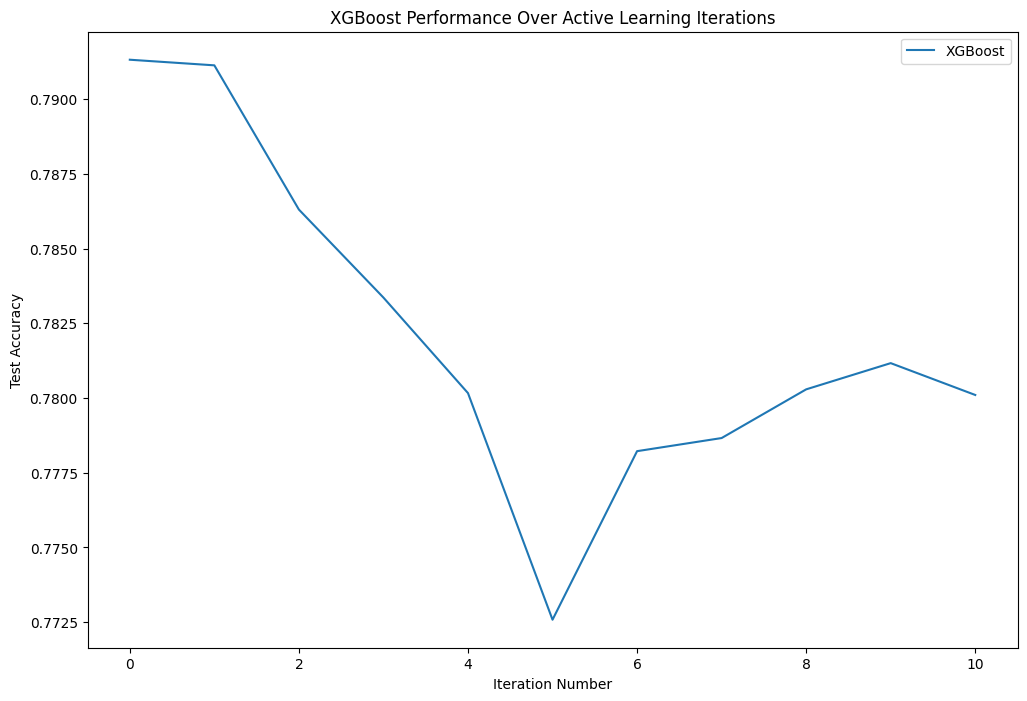

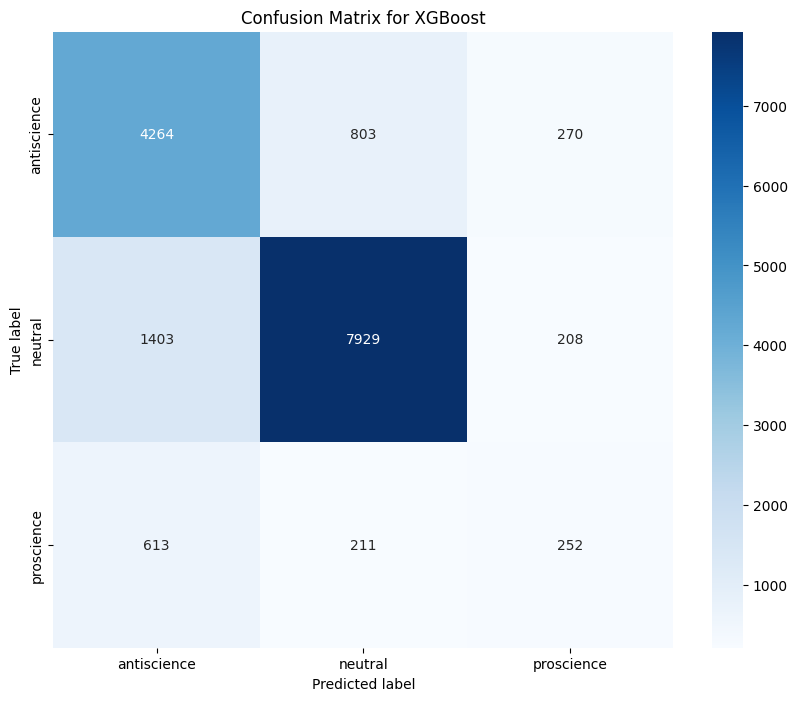

              precision    recall  f1-score   support

 antiscience       0.68      0.80      0.73      5337
     neutral       0.89      0.83      0.86      9540
  proscience       0.35      0.23      0.28      1076

    accuracy                           0.78     15953
   macro avg       0.64      0.62      0.62     15953
weighted avg       0.78      0.78      0.78     15953



In [15]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from modAL.models import ActiveLearner
from modAL.uncertainty import classifier_uncertainty
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import logging
from typing import List, Tuple, Dict
import time
import matplotlib.pyplot as plt
import seaborn as sns

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

class XGBoostActiveLearningPipeline:
    def __init__(self, data_file: str, embedding_column: str, label_column: str, 
                 test_size: float = 0.2, initial_labeled_ratio: float = 0.3, random_state: int = 42):
        self.data_file = data_file
        self.embedding_column = embedding_column
        self.label_column = label_column
        self.test_size = test_size
        self.initial_labeled_ratio = initial_labeled_ratio
        self.random_state = random_state
        self.le = LabelEncoder()
        
        self._log_init_info()
        
    def _log_init_info(self) -> None:
        logger.info("Initializing XGBoostActiveLearningPipeline")
        logger.info(f"Data file: {self.data_file}")
        logger.info(f"Embedding column: {self.embedding_column}")
        logger.info(f"Label column: {self.label_column}")
        logger.info(f"Test size: {self.test_size}")
        logger.info(f"Initial labeled ratio: {self.initial_labeled_ratio}")
        logger.info(f"Random state: {self.random_state}")

    def load_and_preprocess_data(self) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        logger.info("Loading and preprocessing data")
        start_time = time.time()
        
        # Load data in chunks
        chunks = pd.read_csv(self.data_file, chunksize=10000)
        data_list = []
        for chunk in chunks:
            chunk[self.embedding_column] = chunk[self.embedding_column].apply(lambda x: np.fromstring(x.strip('[]'), sep=' '))
            data_list.append(chunk)
        data = pd.concat(data_list)
        
        self.le.fit(data[self.label_column])
        data['encoded_label'] = self.le.transform(data[self.label_column])
        
        X = np.stack(data[self.embedding_column].values)
        y = data['encoded_label'].values
        
        # Split into train and test
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=self.test_size, random_state=self.random_state, stratify=y)
        
        # Split the training data into initial labeled set and pool
        X_initial, X_pool, y_initial, y_pool = train_test_split(
            X_train, y_train, train_size=self.initial_labeled_ratio, 
            random_state=self.random_state, stratify=y_train
        )
        
        end_time = time.time()
        logger.info(f"Data loaded and preprocessed in {end_time - start_time:.2f} seconds")
        logger.info(f"Original data shape: {X.shape}")
        logger.info(f"Initial labeled data shape: {X_initial.shape}")
        logger.info(f"Test data shape: {X_test.shape}")
        logger.info(f"Encoded labels: {self.le.classes_}")
        
        return X_initial, y_initial, X_pool, y_pool, X_test, y_test
        
    def entropy_ipw_sampling(self, learner, X_pool: np.ndarray, n_instances: int, y_pool: np.ndarray) -> np.ndarray:
        """
        Query strategy combining entropy sampling and inverse propensity weighting (IPW)
        """
        # Compute entropy scores for each sample in the pool
        entropy_scores = classifier_uncertainty(learner, X_pool)
        
        # Calculate class frequencies in the pool
        class_counts = np.bincount(y_pool)
        class_probs = class_counts / len(y_pool)
        
        # Inverse propensity weights (IPW)
        ipw = 1 / (class_probs + 1e-6)  # Avoid division by zero
        
        # Apply IPW to entropy scores based on the class of each sample in the pool
        sample_weights = np.array([ipw[label] for label in y_pool])
        weighted_scores = entropy_scores * sample_weights
        
        # Select n_instances with the highest weighted scores
        query_idx = np.argsort(weighted_scores)[-n_instances:]
        
        return query_idx

    def train_with_active_learning(self, X_initial: np.ndarray, y_initial: np.ndarray, 
                                   X_pool: np.ndarray, y_pool: np.ndarray, X_test: np.ndarray, y_test: np.ndarray, 
                                   n_queries: int = 50, n_instances_per_query: int = 500) -> Tuple[str, List[float], List[float], np.ndarray]:
        logger.info("Starting active learning with XGBoost")
        start_time = time.time()

        # Initialize XGBoost model
        xgb_model = XGBClassifier(
            objective='multi:softprob',
            num_class=len(self.le.classes_),
            random_state=self.random_state,
            n_jobs=-1,  # Use all available cores
            learning_rate=0.1,
            n_estimators=100,
            max_depth=6,
            min_child_weight=1,
            gamma=0,
            subsample=0.8,
            colsample_bytree=0.8
        )

        # Create active learner
        learner = ActiveLearner(
            estimator=xgb_model,
            X_training=X_initial,
            y_training=y_initial
        )

        performance_history = []
        auc_history = []  # Track AUC-ROC score
        best_accuracy = 0
        iterations_without_improvement = 0
        max_iterations_without_improvement = 10

        for iteration in tqdm(range(n_queries), desc="Active Learning Progress"):
            query_idx = self.entropy_ipw_sampling(learner, X_pool, n_instances_per_query, y_pool)
            
            learner.teach(X_pool[query_idx], y_pool[query_idx])
            
            X_pool = np.delete(X_pool, query_idx, axis=0)
            y_pool = np.delete(y_pool, query_idx)
            
            y_pred = learner.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            performance_history.append(accuracy)
            
            # Predict probabilities and calculate AUC-ROC score
            y_proba = learner.predict_proba(X_test)
            auc_roc = roc_auc_score(y_test, y_proba, multi_class='ovo', average='macro')
            auc_history.append(auc_roc)

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                iterations_without_improvement = 0
                self.best_model = learner
            else:
                iterations_without_improvement += 1

            if (iteration + 1) % 5 == 0:
                logger.info(f"XGBoost - Iteration {iteration + 1}/{n_queries}: Accuracy = {accuracy:.4f}, AUC-ROC = {auc_roc:.4f}")

            if iterations_without_improvement >= max_iterations_without_improvement:
                logger.info(f"XGBoost - Early stopping at iteration {iteration + 1} due to no improvement")
                break

        end_time = time.time()
        logger.info(f"XGBoost - Active learning completed in {end_time - start_time:.2f} seconds")
        logger.info(f"XGBoost - Final accuracy: {performance_history[-1]:.4f}, Final AUC-ROC: {auc_history[-1]:.4f}")

        y_pred_final = learner.predict(X_test)
        cm = confusion_matrix(y_test, y_pred_final)
        
        return "XGBoost", performance_history, auc_history, cm

    def run_pipeline(self) -> Tuple[Dict[str, List[float]], Dict[str, np.ndarray], str]:
        logger.info("Starting XGBoost active learning pipeline")
        start_time = time.time()

        X_initial, y_initial, X_pool, y_pool, X_test, y_test = self.load_and_preprocess_data()

        model_name, performance_history, auc_history, cm = self.train_with_active_learning(
            X_initial, y_initial, X_pool, y_pool, X_test, y_test
        )

        self.model_performance = {model_name: performance_history}
        self.confusion_matrices = {model_name: cm}
        
        end_time = time.time()
        logger.info(f"XGBoost Active Learning Pipeline completed in {end_time - start_time:.2f} seconds")
        
        logger.info(f"{model_name} - Initial accuracy: {performance_history[0]:.4f}, Final accuracy: {performance_history[-1]:.4f}")

        # Generate classification report
        y_pred = self.best_model.predict(X_test)
        class_report = classification_report(y_test, y_pred, target_names=self.le.classes_)
        logger.info("Classification Report:\n" + class_report)

        return self.model_performance, self.confusion_matrices, class_report

    def plot_results(self) -> None:
        plt.figure(figsize=(12, 8))
        for model_name, accuracies in self.model_performance.items():
            plt.plot(accuracies, label=model_name)
        plt.title('XGBoost Performance Over Active Learning Iterations')
        plt.xlabel('Iteration Number')
        plt.ylabel('Test Accuracy')
        plt.legend()
        plt.show()

    def plot_confusion_matrix(self) -> None:
        for model_name, cm in self.confusion_matrices.items():
            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=self.le.classes_, yticklabels=self.le.classes_)
            plt.title(f'Confusion Matrix for {model_name}')
            plt.ylabel('True label')
            plt.xlabel('Predicted label')
            plt.show()

# Example usage in a notebook:
pipeline = XGBoostActiveLearningPipeline("sbert_llama_classifications.csv", "dense_embedding", "cleaned_classification")
results, confusion_matrices, class_report = pipeline.run_pipeline()
pipeline.plot_results()
pipeline.plot_confusion_matrix()
print(class_report)

## QBC with SMOTE + DISTANCE (highest recall on Proscience, with 0.46, but lowest on Proscience -- try with UDA on Proscience, and see what happens...)

2024-09-23 11:33:55,279 - INFO - Initializing QBCActiveLearningPipeline
2024-09-23 11:33:55,279 - INFO - Data file: sbert_data_with_distance_features.csv
2024-09-23 11:33:55,279 - INFO - Embedding column: dense_embedding
2024-09-23 11:33:55,280 - INFO - Label column: cleaned_classification
2024-09-23 11:33:55,280 - INFO - Distance features: ['distance_to_antiscience', 'distance_to_neutral', 'distance_to_proscience']
2024-09-23 11:33:55,280 - INFO - Test size: 0.2
2024-09-23 11:33:55,281 - INFO - Initial labeled ratio: 0.3
2024-09-23 11:33:55,282 - INFO - Random state: 42
2024-09-23 11:33:55,283 - INFO - Starting QBC active learning pipeline
2024-09-23 11:33:55,284 - INFO - Loading and preprocessing data
2024-09-23 11:34:10,026 - INFO - Data loaded and preprocessed in 14.74 seconds
2024-09-23 11:34:10,026 - INFO - Original data shape: (79763, 387)
2024-09-23 11:34:10,026 - INFO - Resampled training data shape: (114480, 387)
2024-09-23 11:34:10,026 - INFO - Test data shape: (15953, 387)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065248 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 98685
[LightGBM] [Info] Number of data points in the train set: 34344, number of used features: 387
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


Active Learning Progress:   0%|          | 0/50 [00:00<?, ?it/s]

c:\Users\nrosso\Documents\thesis_project\thesis_env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053830 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 98685
[LightGBM] [Info] Number of data points in the train set: 34844, number of used features: 387
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


c:\Users\nrosso\Documents\thesis_project\thesis_env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048541 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 98685
[LightGBM] [Info] Number of data points in the train set: 35344, number of used features: 387
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


c:\Users\nrosso\Documents\thesis_project\thesis_env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053636 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 98685
[LightGBM] [Info] Number of data points in the train set: 35844, number of used features: 387
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


c:\Users\nrosso\Documents\thesis_project\thesis_env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.078327 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 98685
[LightGBM] [Info] Number of data points in the train set: 36344, number of used features: 387
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


c:\Users\nrosso\Documents\thesis_project\thesis_env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.094626 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 98685
[LightGBM] [Info] Number of data points in the train set: 36844, number of used features: 387
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


2024-09-23 11:35:39,278 - INFO - QBC - Iteration 5/50: Accuracy = 0.7062, AUC-ROC = 0.8362
c:\Users\nrosso\Documents\thesis_project\thesis_env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.095090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 98685
[LightGBM] [Info] Number of data points in the train set: 37344, number of used features: 387
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


c:\Users\nrosso\Documents\thesis_project\thesis_env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.089885 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 98685
[LightGBM] [Info] Number of data points in the train set: 37844, number of used features: 387
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


c:\Users\nrosso\Documents\thesis_project\thesis_env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.100223 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 98685
[LightGBM] [Info] Number of data points in the train set: 38344, number of used features: 387
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


c:\Users\nrosso\Documents\thesis_project\thesis_env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.096029 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 98685
[LightGBM] [Info] Number of data points in the train set: 38844, number of used features: 387
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


c:\Users\nrosso\Documents\thesis_project\thesis_env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.094179 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 98685
[LightGBM] [Info] Number of data points in the train set: 39344, number of used features: 387
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


2024-09-23 11:37:10,293 - INFO - QBC - Iteration 10/50: Accuracy = 0.7119, AUC-ROC = 0.8367
c:\Users\nrosso\Documents\thesis_project\thesis_env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.094865 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 98685
[LightGBM] [Info] Number of data points in the train set: 39844, number of used features: 387
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


c:\Users\nrosso\Documents\thesis_project\thesis_env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.088097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 98685
[LightGBM] [Info] Number of data points in the train set: 40344, number of used features: 387
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


c:\Users\nrosso\Documents\thesis_project\thesis_env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.094946 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 98685
[LightGBM] [Info] Number of data points in the train set: 40844, number of used features: 387
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


c:\Users\nrosso\Documents\thesis_project\thesis_env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.167522 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 98685
[LightGBM] [Info] Number of data points in the train set: 41344, number of used features: 387
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


c:\Users\nrosso\Documents\thesis_project\thesis_env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.125832 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 98685
[LightGBM] [Info] Number of data points in the train set: 41844, number of used features: 387
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


2024-09-23 11:39:11,283 - INFO - QBC - Iteration 15/50: Accuracy = 0.7165, AUC-ROC = 0.8370
c:\Users\nrosso\Documents\thesis_project\thesis_env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.105651 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 98685
[LightGBM] [Info] Number of data points in the train set: 42344, number of used features: 387
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


c:\Users\nrosso\Documents\thesis_project\thesis_env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.126291 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 98685
[LightGBM] [Info] Number of data points in the train set: 42844, number of used features: 387
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


c:\Users\nrosso\Documents\thesis_project\thesis_env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.095157 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 98685
[LightGBM] [Info] Number of data points in the train set: 43344, number of used features: 387
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


c:\Users\nrosso\Documents\thesis_project\thesis_env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.109845 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 98685
[LightGBM] [Info] Number of data points in the train set: 43844, number of used features: 387
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


c:\Users\nrosso\Documents\thesis_project\thesis_env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.078620 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 98685
[LightGBM] [Info] Number of data points in the train set: 44344, number of used features: 387
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


2024-09-23 11:40:58,849 - INFO - QBC - Iteration 20/50: Accuracy = 0.7182, AUC-ROC = 0.8375
c:\Users\nrosso\Documents\thesis_project\thesis_env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.105888 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 98685
[LightGBM] [Info] Number of data points in the train set: 44844, number of used features: 387
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


c:\Users\nrosso\Documents\thesis_project\thesis_env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070632 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 98685
[LightGBM] [Info] Number of data points in the train set: 45344, number of used features: 387
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


c:\Users\nrosso\Documents\thesis_project\thesis_env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.101434 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 98685
[LightGBM] [Info] Number of data points in the train set: 45844, number of used features: 387
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


c:\Users\nrosso\Documents\thesis_project\thesis_env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.108954 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 98685
[LightGBM] [Info] Number of data points in the train set: 46344, number of used features: 387
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


c:\Users\nrosso\Documents\thesis_project\thesis_env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.095395 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 98685
[LightGBM] [Info] Number of data points in the train set: 46844, number of used features: 387
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


2024-09-23 11:42:27,125 - INFO - QBC - Iteration 25/50: Accuracy = 0.7198, AUC-ROC = 0.8370
c:\Users\nrosso\Documents\thesis_project\thesis_env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.107999 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 98685
[LightGBM] [Info] Number of data points in the train set: 47344, number of used features: 387
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


c:\Users\nrosso\Documents\thesis_project\thesis_env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.118615 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 98685
[LightGBM] [Info] Number of data points in the train set: 47844, number of used features: 387
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


c:\Users\nrosso\Documents\thesis_project\thesis_env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.112440 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 98685
[LightGBM] [Info] Number of data points in the train set: 48344, number of used features: 387
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


c:\Users\nrosso\Documents\thesis_project\thesis_env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.107513 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 98685
[LightGBM] [Info] Number of data points in the train set: 48844, number of used features: 387
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


c:\Users\nrosso\Documents\thesis_project\thesis_env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.078624 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 98685
[LightGBM] [Info] Number of data points in the train set: 49344, number of used features: 387
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


2024-09-23 11:44:00,878 - INFO - QBC - Iteration 30/50: Accuracy = 0.7251, AUC-ROC = 0.8379
c:\Users\nrosso\Documents\thesis_project\thesis_env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.120797 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 98685
[LightGBM] [Info] Number of data points in the train set: 49844, number of used features: 387
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


c:\Users\nrosso\Documents\thesis_project\thesis_env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.093119 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 98685
[LightGBM] [Info] Number of data points in the train set: 50344, number of used features: 387
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


c:\Users\nrosso\Documents\thesis_project\thesis_env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.115623 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 98685
[LightGBM] [Info] Number of data points in the train set: 50844, number of used features: 387
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


c:\Users\nrosso\Documents\thesis_project\thesis_env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.119315 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 98685
[LightGBM] [Info] Number of data points in the train set: 51344, number of used features: 387
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


c:\Users\nrosso\Documents\thesis_project\thesis_env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.122056 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 98685
[LightGBM] [Info] Number of data points in the train set: 51844, number of used features: 387
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


2024-09-23 11:45:37,655 - INFO - QBC - Iteration 35/50: Accuracy = 0.7283, AUC-ROC = 0.8380
c:\Users\nrosso\Documents\thesis_project\thesis_env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.095303 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 98685
[LightGBM] [Info] Number of data points in the train set: 52344, number of used features: 387
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


c:\Users\nrosso\Documents\thesis_project\thesis_env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.123584 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 98685
[LightGBM] [Info] Number of data points in the train set: 52844, number of used features: 387
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


c:\Users\nrosso\Documents\thesis_project\thesis_env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.119421 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 98685
[LightGBM] [Info] Number of data points in the train set: 53344, number of used features: 387
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


c:\Users\nrosso\Documents\thesis_project\thesis_env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.104617 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 98685
[LightGBM] [Info] Number of data points in the train set: 53844, number of used features: 387
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


c:\Users\nrosso\Documents\thesis_project\thesis_env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.093472 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 98685
[LightGBM] [Info] Number of data points in the train set: 54344, number of used features: 387
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


2024-09-23 11:47:20,298 - INFO - QBC - Iteration 40/50: Accuracy = 0.7304, AUC-ROC = 0.8379
c:\Users\nrosso\Documents\thesis_project\thesis_env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.111703 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 98685
[LightGBM] [Info] Number of data points in the train set: 54844, number of used features: 387
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


c:\Users\nrosso\Documents\thesis_project\thesis_env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.176057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 98685
[LightGBM] [Info] Number of data points in the train set: 55344, number of used features: 387
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


c:\Users\nrosso\Documents\thesis_project\thesis_env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.127813 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 98685
[LightGBM] [Info] Number of data points in the train set: 55844, number of used features: 387
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


c:\Users\nrosso\Documents\thesis_project\thesis_env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.116361 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 98685
[LightGBM] [Info] Number of data points in the train set: 56344, number of used features: 387
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


c:\Users\nrosso\Documents\thesis_project\thesis_env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.138685 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 98685
[LightGBM] [Info] Number of data points in the train set: 56844, number of used features: 387
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


2024-09-23 11:49:05,082 - INFO - QBC - Iteration 45/50: Accuracy = 0.7312, AUC-ROC = 0.8378
c:\Users\nrosso\Documents\thesis_project\thesis_env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.108765 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 98685
[LightGBM] [Info] Number of data points in the train set: 57344, number of used features: 387
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


c:\Users\nrosso\Documents\thesis_project\thesis_env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.106415 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 98685
[LightGBM] [Info] Number of data points in the train set: 57844, number of used features: 387
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


c:\Users\nrosso\Documents\thesis_project\thesis_env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.134632 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 98685
[LightGBM] [Info] Number of data points in the train set: 58344, number of used features: 387
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


c:\Users\nrosso\Documents\thesis_project\thesis_env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.126698 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 98685
[LightGBM] [Info] Number of data points in the train set: 58844, number of used features: 387
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


c:\Users\nrosso\Documents\thesis_project\thesis_env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.132100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 98685
[LightGBM] [Info] Number of data points in the train set: 59344, number of used features: 387
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


2024-09-23 11:50:52,012 - INFO - QBC - Iteration 50/50: Accuracy = 0.7320, AUC-ROC = 0.8371
2024-09-23 11:50:52,015 - INFO - QBC - Active learning completed in 1001.86 seconds
2024-09-23 11:50:52,016 - INFO - QBC - Final accuracy: 0.7320, Final AUC-ROC: 0.8371
2024-09-23 11:50:52,409 - INFO - QBC Active Learning Pipeline completed in 1017.13 seconds
2024-09-23 11:50:52,410 - INFO - QBC - Initial accuracy: 0.7070, Final accuracy: 0.7320
2024-09-23 11:50:52,410 - INFO - QBC - Initial AUC-ROC: 0.8359, Final AUC-ROC: 0.8371
2024-09-23 11:50:52,800 - INFO - Classification Report:
              precision    recall  f1-score   support

 antiscience       0.73      0.57      0.64      5337
     neutral       0.85      0.85      0.85      9540
  proscience       0.23      0.46      0.30      1076

    accuracy                           0.73     15953
   macro avg       0.60      0.63      0.60     15953
weighted avg       0.77      0.73      0.74     15953



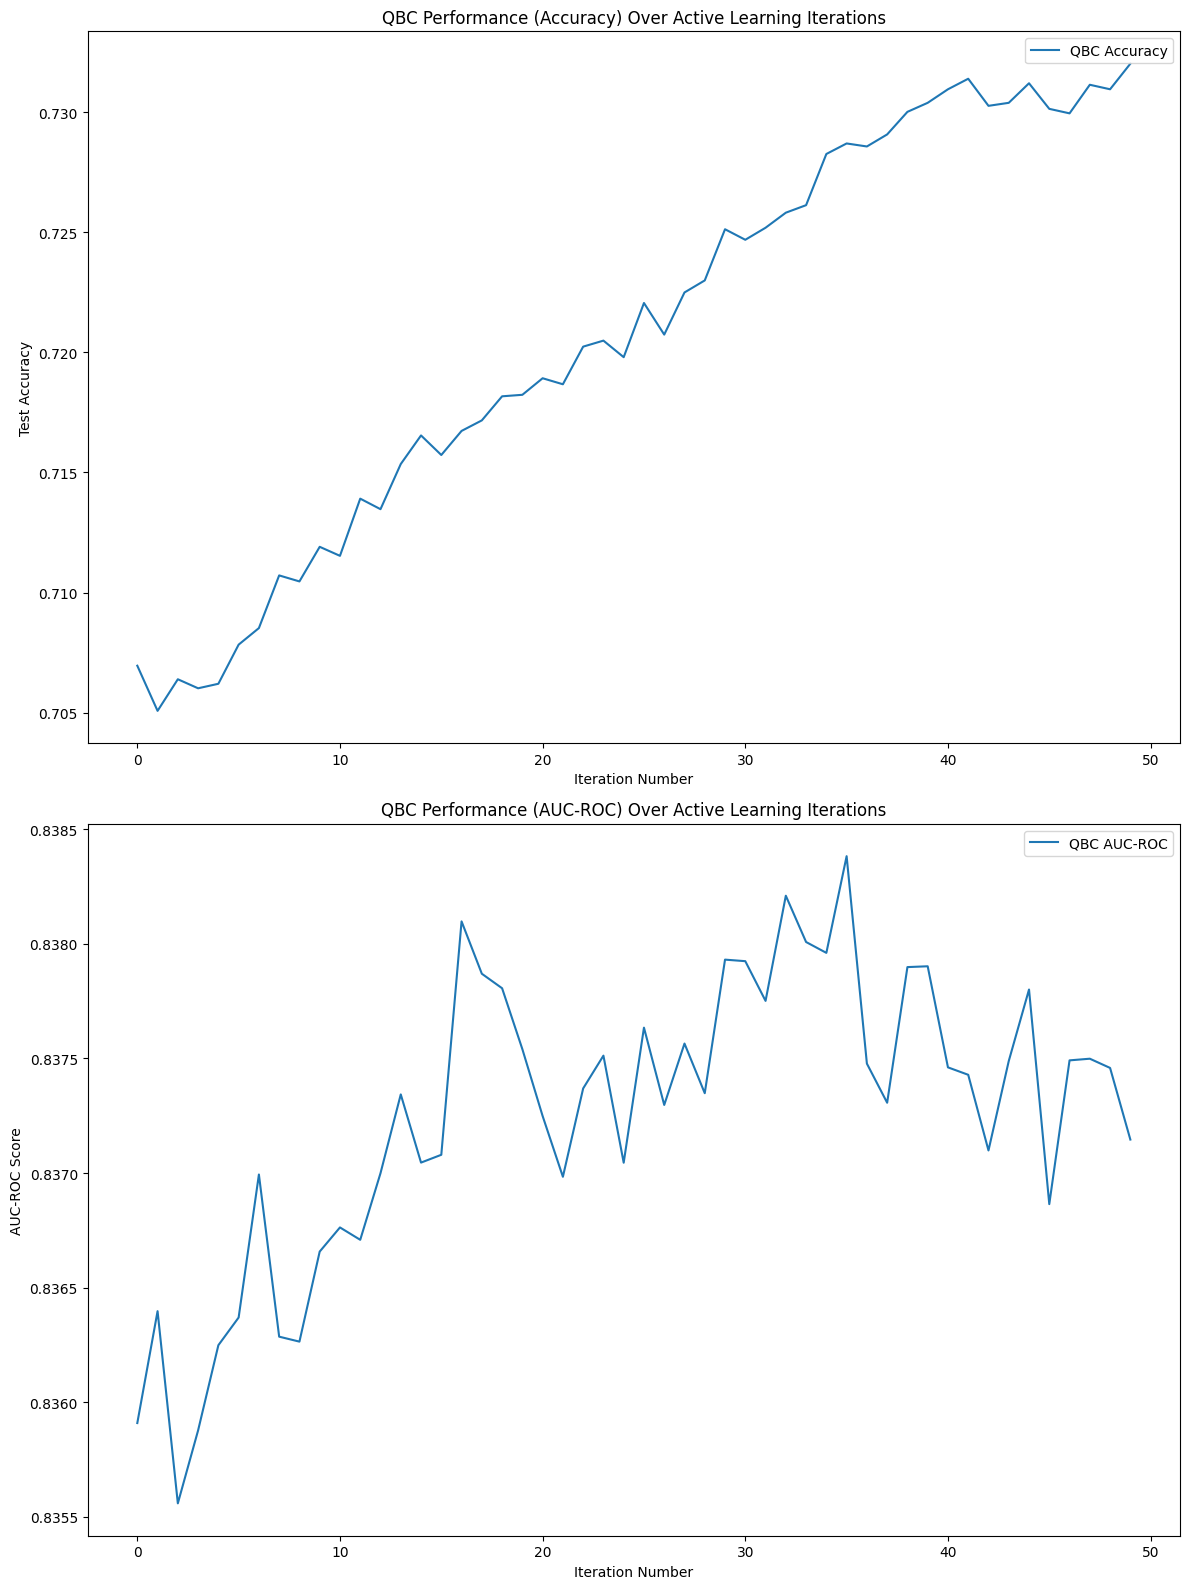

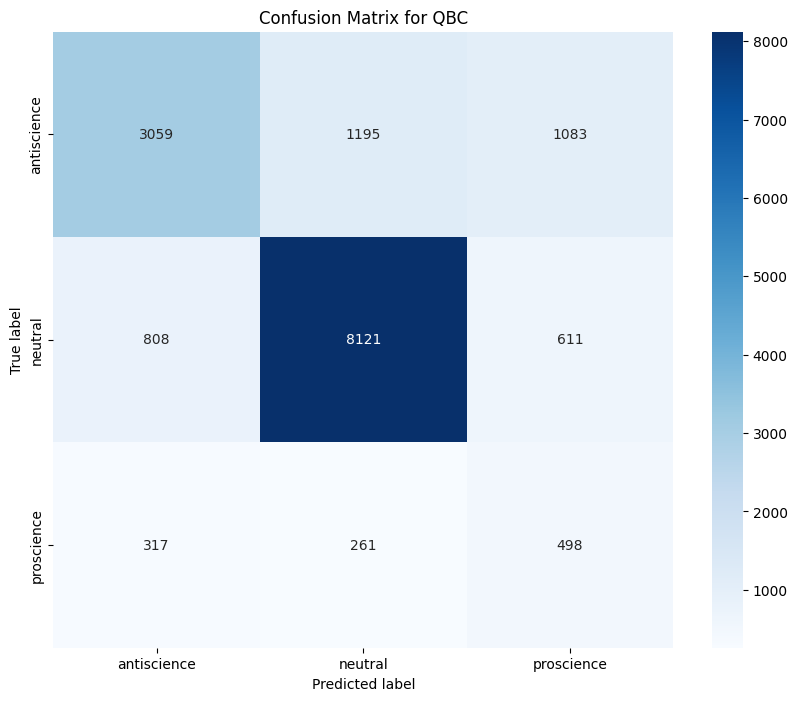

              precision    recall  f1-score   support

 antiscience       0.73      0.57      0.64      5337
     neutral       0.85      0.85      0.85      9540
  proscience       0.23      0.46      0.30      1076

    accuracy                           0.73     15953
   macro avg       0.60      0.63      0.60     15953
weighted avg       0.77      0.73      0.74     15953



In [26]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMClassifier
from modAL.models import Committee
from modAL.disagreement import vote_entropy_sampling
from tqdm.notebook import tqdm
import logging
from typing import List, Tuple, Dict
import time
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

class QBCActiveLearningPipeline:
    def __init__(self, data_file: str, embedding_column: str, label_column: str, 
                 distance_features: List[str] = ['distance_to_antiscience', 'distance_to_neutral', 'distance_to_proscience'],
                 test_size: float = 0.2, initial_labeled_ratio: float = 0.3, random_state: int = 42):
        self.data_file = data_file
        self.embedding_column = embedding_column
        self.label_column = label_column
        self.distance_features = distance_features
        self.test_size = test_size
        self.initial_labeled_ratio = initial_labeled_ratio
        self.random_state = random_state
        self.le = LabelEncoder()
        
        self._log_init_info()
        
    def _log_init_info(self) -> None:
        logger.info("Initializing QBCActiveLearningPipeline")
        logger.info(f"Data file: {self.data_file}")
        logger.info(f"Embedding column: {self.embedding_column}")
        logger.info(f"Label column: {self.label_column}")
        logger.info(f"Distance features: {self.distance_features}")
        logger.info(f"Test size: {self.test_size}")
        logger.info(f"Initial labeled ratio: {self.initial_labeled_ratio}")
        logger.info(f"Random state: {self.random_state}")

    def load_and_preprocess_data(self) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        logger.info("Loading and preprocessing data")
        start_time = time.time()
        
        # Load data in chunks
        chunks = pd.read_csv(self.data_file, chunksize=10000)
        data_list = []
        for chunk in chunks:
            chunk[self.embedding_column] = chunk[self.embedding_column].apply(lambda x: np.fromstring(x.strip('[]'), sep=' '))
            data_list.append(chunk)
        data = pd.concat(data_list)
        
        self.le.fit(data[self.label_column])
        data['encoded_label'] = self.le.transform(data[self.label_column])
        
        # Combine embedding with distance features
        X_embedding = np.stack(data[self.embedding_column].values)
        X_distance = data[self.distance_features].values
        X = np.hstack((X_embedding, X_distance))
        y = data['encoded_label'].values
        
        # Split into train and test first
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=self.test_size, random_state=self.random_state, stratify=y)
        
        # Apply SMOTE only to the training data
        smote = SMOTE(random_state=self.random_state)
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
        
        # Split the resampled training data into initial labeled set and pool
        X_initial, X_pool, y_initial, y_pool = train_test_split(
            X_train_resampled, y_train_resampled, train_size=self.initial_labeled_ratio, 
            random_state=self.random_state, stratify=y_train_resampled
        )
        
        end_time = time.time()
        logger.info(f"Data loaded and preprocessed in {end_time - start_time:.2f} seconds")
        logger.info(f"Original data shape: {X.shape}")
        logger.info(f"Resampled training data shape: {X_train_resampled.shape}")
        logger.info(f"Test data shape: {X_test.shape}")
        logger.info(f"Encoded labels: {self.le.classes_}")
        logger.info(f"Class distribution in resampled training set: {np.bincount(y_train_resampled)}")
        logger.info(f"Class distribution in test set: {np.bincount(y_test)}")
        
        return X_initial, y_initial, X_pool, y_pool, X_test, y_test

    def train_with_active_learning(self, X_initial: np.ndarray, y_initial: np.ndarray, 
                                   X_pool: np.ndarray, y_pool: np.ndarray, X_test: np.ndarray, y_test: np.ndarray, 
                                   n_queries: int = 50, n_instances_per_query: int = 500) -> Tuple[str, List[float], List[float], np.ndarray]:
        logger.info("Starting active learning with QBC")
        start_time = time.time()

        # Initialize base models
        lr_model = LogisticRegression(multi_class='ovr', class_weight='balanced', random_state=self.random_state)
        lgb_model = LGBMClassifier(class_weight='balanced', random_state=self.random_state)
        gnb_model = GaussianNB()

        # Wrap base models in ActiveLearner
        learner_lr = ActiveLearner(estimator=lr_model, X_training=X_initial, y_training=y_initial)
        learner_lgb = ActiveLearner(estimator=lgb_model, X_training=X_initial, y_training=y_initial)
        learner_gnb = ActiveLearner(estimator=gnb_model, X_training=X_initial, y_training=y_initial)

        # Create committee
        committee = Committee(
            learner_list=[
                learner_lr,
                learner_lgb,
                learner_gnb
            ],
            query_strategy=vote_entropy_sampling
        )

        performance_history = []
        auc_history = []
        best_accuracy = 0
        iterations_without_improvement = 0
        max_iterations_without_improvement = 10

        for iteration in tqdm(range(n_queries), desc="Active Learning Progress"):
            query_idx, _ = committee.query(X_pool, n_instances=n_instances_per_query)
            
            committee.teach(X_pool[query_idx], y_pool[query_idx])
            
            X_pool = np.delete(X_pool, query_idx, axis=0)
            y_pool = np.delete(y_pool, query_idx)
            
            y_pred = committee.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            performance_history.append(accuracy)
            
            # Predict probabilities and calculate AUC-ROC score
            y_proba = committee.predict_proba(X_test)
            auc_roc = roc_auc_score(y_test, y_proba, multi_class='ovo', average='macro')
            auc_history.append(auc_roc)

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                iterations_without_improvement = 0
                self.best_model = committee
            else:
                iterations_without_improvement += 1

            if (iteration + 1) % 5 == 0:
                logger.info(f"QBC - Iteration {iteration + 1}/{n_queries}: Accuracy = {accuracy:.4f}, AUC-ROC = {auc_roc:.4f}")

            if iterations_without_improvement >= max_iterations_without_improvement:
                logger.info(f"QBC - Early stopping at iteration {iteration + 1} due to no improvement")
                break

        end_time = time.time()
        logger.info(f"QBC - Active learning completed in {end_time - start_time:.2f} seconds")
        logger.info(f"QBC - Final accuracy: {performance_history[-1]:.4f}, Final AUC-ROC: {auc_history[-1]:.4f}")

        y_pred_final = committee.predict(X_test)
        cm = confusion_matrix(y_test, y_pred_final)
        
        return "QBC", performance_history, auc_history, cm

    def run_pipeline(self) -> Tuple[Dict[str, List[float]], Dict[str, List[float]], Dict[str, np.ndarray], str]:
        logger.info("Starting QBC active learning pipeline")
        start_time = time.time()

        X_initial, y_initial, X_pool, y_pool, X_test, y_test = self.load_and_preprocess_data()

        model_name, performance_history, auc_history, cm = self.train_with_active_learning(
            X_initial, y_initial, X_pool, y_pool, X_test, y_test
        )

        self.model_performance = {model_name: performance_history}
        self.model_auc = {model_name: auc_history}
        self.confusion_matrices = {model_name: cm}
        
        end_time = time.time()
        logger.info(f"QBC Active Learning Pipeline completed in {end_time - start_time:.2f} seconds")
        
        logger.info(f"{model_name} - Initial accuracy: {performance_history[0]:.4f}, Final accuracy: {performance_history[-1]:.4f}")
        logger.info(f"{model_name} - Initial AUC-ROC: {auc_history[0]:.4f}, Final AUC-ROC: {auc_history[-1]:.4f}")

        # Generate classification report
        y_pred = self.best_model.predict(X_test)
        class_report = classification_report(y_test, y_pred, target_names=self.le.classes_)
        logger.info("Classification Report:\n" + class_report)

        return self.model_performance, self.model_auc, self.confusion_matrices, class_report

    def plot_results(self) -> None:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 16))
        
        for model_name, accuracies in self.model_performance.items():
            ax1.plot(accuracies, label=f"{model_name} Accuracy")
        ax1.set_title('QBC Performance (Accuracy) Over Active Learning Iterations')
        ax1.set_xlabel('Iteration Number')
        ax1.set_ylabel('Test Accuracy')
        ax1.legend()
        
        for model_name, auc_scores in self.model_auc.items():
            ax2.plot(auc_scores, label=f"{model_name} AUC-ROC")
        ax2.set_title('QBC Performance (AUC-ROC) Over Active Learning Iterations')
        ax2.set_xlabel('Iteration Number')
        ax2.set_ylabel('AUC-ROC Score')
        ax2.legend()
        
        plt.tight_layout()
        plt.show()

    def plot_confusion_matrix(self) -> None:
        for model_name, cm in self.confusion_matrices.items():
            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=self.le.classes_, yticklabels=self.le.classes_)
            plt.title(f'Confusion Matrix for {model_name}')
            plt.ylabel('True label')
            plt.xlabel('Predicted label')
            plt.show()

# Example usage in a notebook:
pipeline = QBCActiveLearningPipeline(
    "sbert_data_with_distance_features.csv", 
    "dense_embedding", 
    "cleaned_classification",
    distance_features=['distance_to_antiscience', 'distance_to_neutral', 'distance_to_proscience']
)
results, auc_results, confusion_matrices, class_report = pipeline.run_pipeline()
pipeline.plot_results()
pipeline.plot_confusion_matrix()
print(class_report)

## QBC with Augmented Data

2024-09-26 16:17:06,879 - INFO - Initializing QBCActiveLearningPipeline
2024-09-26 16:17:06,880 - INFO - Main data file: sbert_data_with_distance_features.csv
2024-09-26 16:17:06,882 - INFO - Augmented data file: cleaned_proscience_da.csv
2024-09-26 16:17:06,883 - INFO - Embedding column: dense_embedding
2024-09-26 16:17:06,884 - INFO - Label column: cleaned_classification
2024-09-26 16:17:06,886 - INFO - Test size: 0.2
2024-09-26 16:17:06,887 - INFO - Initial labeled ratio: 0.3
2024-09-26 16:17:06,889 - INFO - Random state: 42
2024-09-26 16:17:06,890 - INFO - Starting QBC active learning pipeline
2024-09-26 16:17:06,892 - INFO - Loading and preprocessing data
2024-09-26 16:17:24,834 - INFO - Main data shape: (79763, 13)
2024-09-26 16:17:26,164 - INFO - Augmented data shape: (5378, 4)
2024-09-26 16:17:27,044 - INFO - Data loaded and preprocessed in 20.15 seconds
2024-09-26 16:17:27,045 - INFO - Combined training data shape: (69188, 384)
2024-09-26 16:17:27,046 - INFO - Test data shape:

Active Learning Progress:   0%|          | 0/50 [00:00<?, ?it/s]

c:\Users\nrosso\Documents\thesis_project\thesis_env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\nrosso\Documents\thesis_project\thesis_env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\nrosso\Documents\thesis_project\thesis_env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\nrosso\Documents\th

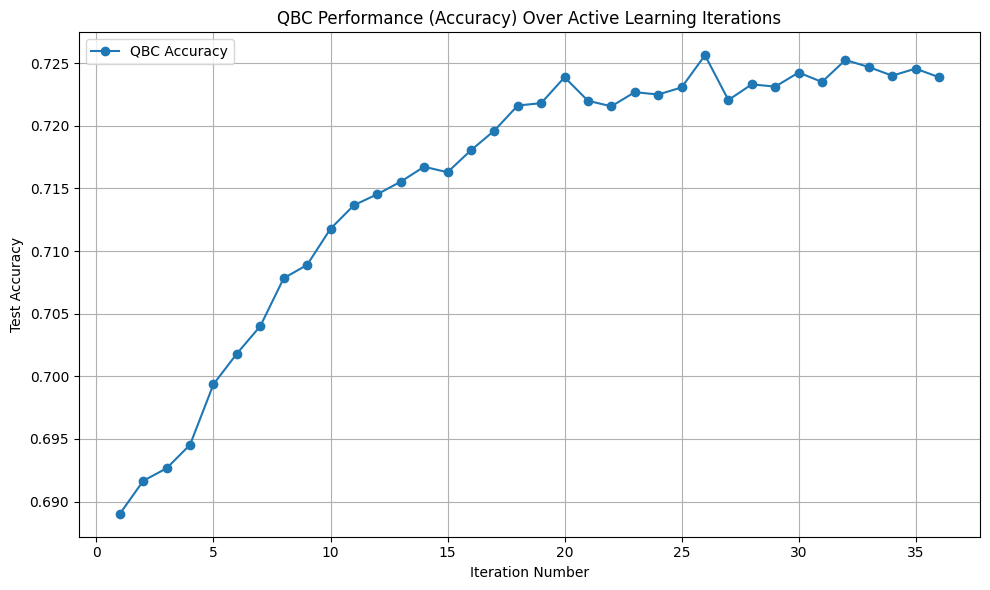

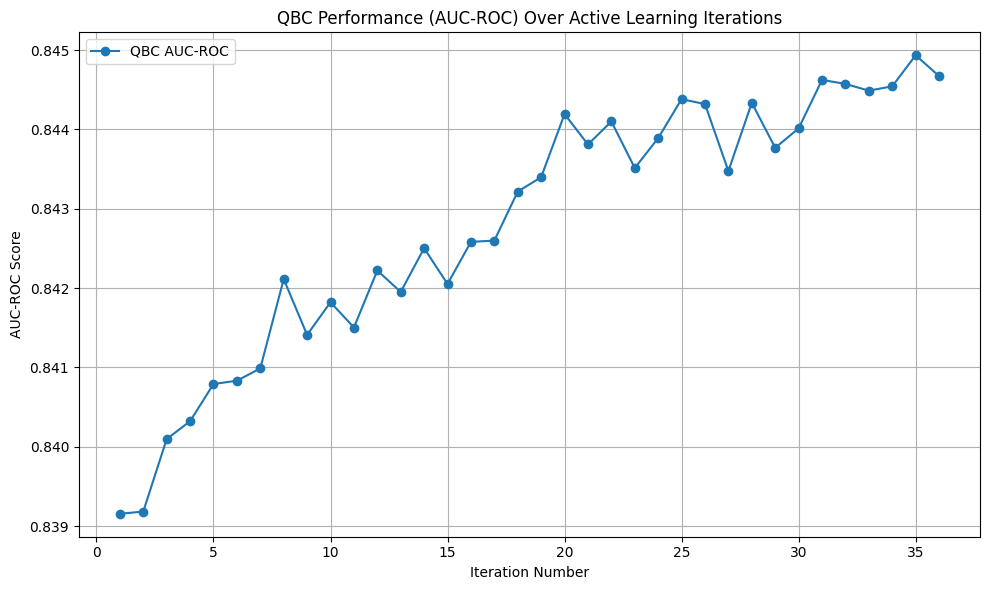

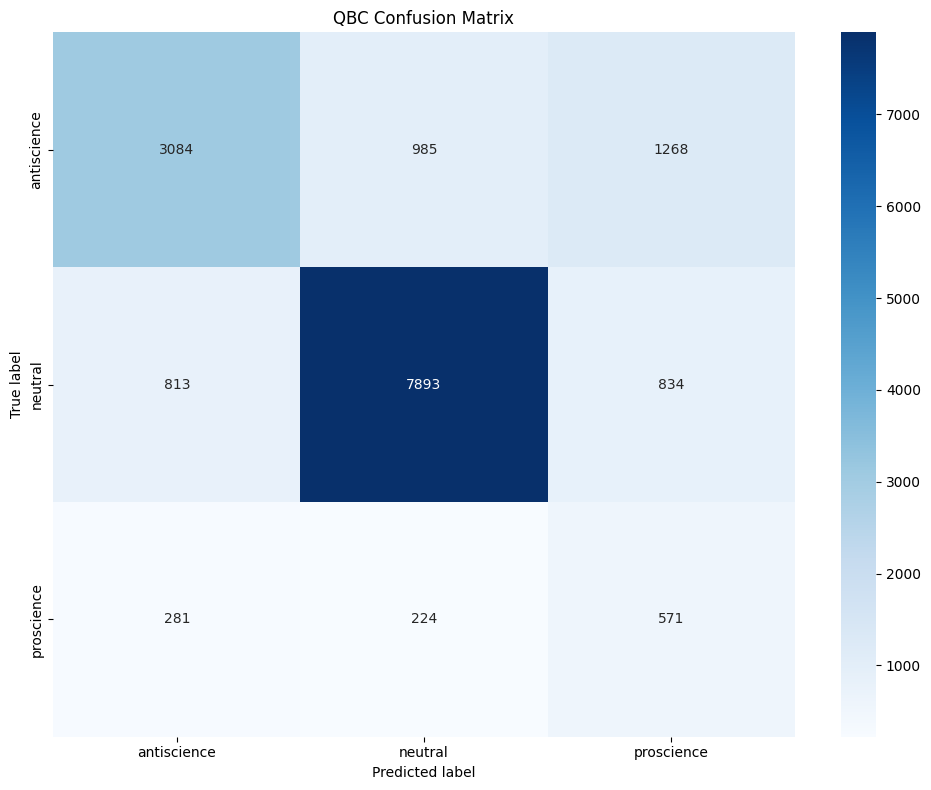

              precision    recall  f1-score   support

 antiscience       0.74      0.58      0.65      5337
     neutral       0.87      0.83      0.85      9540
  proscience       0.21      0.53      0.30      1076

    accuracy                           0.72     15953
   macro avg       0.61      0.65      0.60     15953
weighted avg       0.78      0.72      0.74     15953



In [11]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMClassifier
from modAL.models import Committee, ActiveLearner
from modAL.disagreement import vote_entropy_sampling
from tqdm.notebook import tqdm
import logging
from typing import List, Tuple, Dict
import time
import matplotlib.pyplot as plt
import seaborn as sns

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

class QBCActiveLearningPipeline:
    def __init__(self, main_data_file: str, augmented_data_file: str, embedding_column: str, label_column: str, 
                 test_size: float = 0.2, initial_labeled_ratio: float = 0.3, random_state: int = 42):
        self.main_data_file = main_data_file
        self.augmented_data_file = augmented_data_file
        self.embedding_column = embedding_column
        self.label_column = label_column
        self.test_size = test_size
        self.initial_labeled_ratio = initial_labeled_ratio
        self.random_state = random_state
        self.le = LabelEncoder()
        
        self._log_init_info()
        
    def _log_init_info(self) -> None:
        logger.info("Initializing QBCActiveLearningPipeline")
        logger.info(f"Main data file: {self.main_data_file}")
        logger.info(f"Augmented data file: {self.augmented_data_file}")
        logger.info(f"Embedding column: {self.embedding_column}")
        logger.info(f"Label column: {self.label_column}")
        logger.info(f"Test size: {self.test_size}")
        logger.info(f"Initial labeled ratio: {self.initial_labeled_ratio}")
        logger.info(f"Random state: {self.random_state}")

    def load_and_preprocess_data(self) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        logger.info("Loading and preprocessing data")
        start_time = time.time()
        
        # Load main data
        main_data = self._load_data(self.main_data_file, ' ')
        logger.info(f"Main data shape: {main_data.shape}")
        
        # Load augmented data
        augmented_data = self._load_data(self.augmented_data_file, ',')
        logger.info(f"Augmented data shape: {augmented_data.shape}")
        
        # Encode labels for both datasets
        all_labels = pd.concat([main_data[self.label_column], augmented_data[self.label_column]])
        self.le.fit(all_labels)
        main_data['encoded_label'] = self.le.transform(main_data[self.label_column])
        augmented_data['encoded_label'] = self.le.transform(augmented_data[self.label_column])
        
        # Prepare main data
        X_main = np.stack(main_data[self.embedding_column].values)
        y_main = main_data['encoded_label'].values
        
        # Split main data into train and test
        X_train, X_test, y_train, y_test = train_test_split(X_main, y_main, test_size=self.test_size, 
                                                            random_state=self.random_state, stratify=y_main)
        
        # Prepare augmented data
        X_aug = np.stack(augmented_data[self.embedding_column].values)
        y_aug = augmented_data['encoded_label'].values
        
        # Combine augmented data with training data
        X_train = np.vstack([X_train, X_aug])
        y_train = np.concatenate([y_train, y_aug])
        
        # Split the combined training data into initial labeled set and pool
        X_initial, X_pool, y_initial, y_pool = train_test_split(
            X_train, y_train, train_size=self.initial_labeled_ratio, 
            random_state=self.random_state, stratify=y_train
        )
        
        end_time = time.time()
        logger.info(f"Data loaded and preprocessed in {end_time - start_time:.2f} seconds")
        logger.info(f"Combined training data shape: {X_train.shape}")
        logger.info(f"Test data shape: {X_test.shape}")
        logger.info(f"Initial labeled set shape: {X_initial.shape}")
        logger.info(f"Pool set shape: {X_pool.shape}")
        logger.info(f"Encoded labels: {self.le.classes_}")
        logger.info(f"Class distribution in combined training set: {np.bincount(y_train)}")
        logger.info(f"Class distribution in test set: {np.bincount(y_test)}")
        
        return X_initial, y_initial, X_pool, y_pool, X_test, y_test

    def _load_data(self, file_path: str, separator: str) -> pd.DataFrame:
        chunks = pd.read_csv(file_path, chunksize=10000)
        data_list = []
        for chunk in chunks:
            chunk[self.embedding_column] = chunk[self.embedding_column].apply(lambda x: np.fromstring(x.strip('[]'), sep=separator))
            data_list.append(chunk)
        return pd.concat(data_list)

    def train_with_active_learning(self, X_initial: np.ndarray, y_initial: np.ndarray, 
                                   X_pool: np.ndarray, y_pool: np.ndarray, X_test: np.ndarray, y_test: np.ndarray, 
                                   n_queries: int = 50, n_instances_per_query: int = 500) -> Tuple[str, List[float], List[float], np.ndarray]:
        logger.info("Starting active learning with QBC")
        start_time = time.time()

        # Initialize base models with class weights
        class_weights = {cls: len(y_initial) / (len(self.le.classes_) * np.sum(y_initial == cls)) for cls in range(len(self.le.classes_))}
        
        lr_model = LogisticRegression(multi_class='ovr', class_weight=class_weights, random_state=self.random_state)
        lgb_model = LGBMClassifier(class_weight=class_weights, random_state=self.random_state)
        gnb_model = GaussianNB()

        # Wrap base models in ActiveLearner
        learner_lr = ActiveLearner(estimator=lr_model, X_training=X_initial, y_training=y_initial)
        learner_lgb = ActiveLearner(estimator=lgb_model, X_training=X_initial, y_training=y_initial)
        learner_gnb = ActiveLearner(estimator=gnb_model, X_training=X_initial, y_training=y_initial)

        # Create committee
        committee = Committee(
            learner_list=[learner_lr, learner_lgb, learner_gnb],
            query_strategy=vote_entropy_sampling
        )

        performance_history = []
        auc_history = []
        best_accuracy = 0
        iterations_without_improvement = 0
        max_iterations_without_improvement = 10

        for iteration in tqdm(range(n_queries), desc="Active Learning Progress"):
            query_idx, _ = committee.query(X_pool, n_instances=n_instances_per_query)
            
            committee.teach(X_pool[query_idx], y_pool[query_idx])
            
            X_pool = np.delete(X_pool, query_idx, axis=0)
            y_pool = np.delete(y_pool, query_idx)
            
            y_pred = committee.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            performance_history.append(accuracy)
            
            y_proba = committee.predict_proba(X_test)
            auc_roc = roc_auc_score(y_test, y_proba, multi_class='ovo', average='macro')
            auc_history.append(auc_roc)

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                iterations_without_improvement = 0
                self.best_model = committee
            else:
                iterations_without_improvement += 1

            if (iteration + 1) % 5 == 0:
                logger.info(f"QBC - Iteration {iteration + 1}/{n_queries}: Accuracy = {accuracy:.4f}, AUC-ROC = {auc_roc:.4f}")

            if iterations_without_improvement >= max_iterations_without_improvement:
                logger.info(f"QBC - Early stopping at iteration {iteration + 1} due to no improvement")
                break

        end_time = time.time()
        logger.info(f"QBC - Active learning completed in {end_time - start_time:.2f} seconds")
        logger.info(f"QBC - Final accuracy: {performance_history[-1]:.4f}, Final AUC-ROC: {auc_history[-1]:.4f}")

        y_pred_final = committee.predict(X_test)
        cm = confusion_matrix(y_test, y_pred_final)
        
        return "QBC", performance_history, auc_history, cm

    def run_pipeline(self) -> Tuple[Dict[str, List[float]], Dict[str, List[float]], Dict[str, np.ndarray], str]:
        logger.info("Starting QBC active learning pipeline")
        start_time = time.time()

        X_initial, y_initial, X_pool, y_pool, X_test, y_test = self.load_and_preprocess_data()

        model_name, performance_history, auc_history, cm = self.train_with_active_learning(
            X_initial, y_initial, X_pool, y_pool, X_test, y_test
        )

        self.model_performance = {model_name: performance_history}
        self.model_auc = {model_name: auc_history}
        self.confusion_matrices = {model_name: cm}
        
        end_time = time.time()
        logger.info(f"QBC Active Learning Pipeline completed in {end_time - start_time:.2f} seconds")
        
        logger.info(f"{model_name} - Initial accuracy: {performance_history[0]:.4f}, Final accuracy: {performance_history[-1]:.4f}")
        logger.info(f"{model_name} - Initial AUC-ROC: {auc_history[0]:.4f}, Final AUC-ROC: {auc_history[-1]:.4f}")

        # Generate classification report
        y_pred = self.best_model.predict(X_test)
        class_report = classification_report(y_test, y_pred, target_names=self.le.classes_)
        logger.info("Classification Report:\n" + class_report)

        return self.model_performance, self.model_auc, self.confusion_matrices, class_report

    def plot_results(self) -> None:
        # Plot accuracy
        plt.figure(figsize=(10, 6))
        for model_name, accuracies in self.model_performance.items():
            plt.plot(range(1, len(accuracies) + 1), accuracies, label=f"{model_name} Accuracy", marker='o')
        plt.title('QBC Performance (Accuracy) Over Active Learning Iterations')
        plt.xlabel('Iteration Number')
        plt.ylabel('Test Accuracy')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig('qbc_accuracy_history.png')
        plt.show()

        # Plot AUC-ROC
        plt.figure(figsize=(10, 6))
        for model_name, auc_scores in self.model_auc.items():
            plt.plot(range(1, len(auc_scores) + 1), auc_scores, label=f"{model_name} AUC-ROC", marker='o')
        plt.title('QBC Performance (AUC-ROC) Over Active Learning Iterations')
        plt.xlabel('Iteration Number')
        plt.ylabel('AUC-ROC Score')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig('qbc_auc_roc_history.png')
        plt.show()

    def plot_confusion_matrix(self) -> None:
        for model_name, cm in self.confusion_matrices.items():
            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=self.le.classes_, yticklabels=self.le.classes_)
            plt.title(f'QBC Confusion Matrix')
            plt.ylabel('True label')
            plt.xlabel('Predicted label')
            plt.tight_layout()
            plt.savefig('qbc_confusion_matrix.png')
            plt.show()

# Example usage
main_data_file = "sbert_data_with_distance_features.csv"
augmented_data_file = "cleaned_proscience_da.csv"

pipeline = QBCActiveLearningPipeline(
    main_data_file,
    augmented_data_file,
    "dense_embedding",
    "cleaned_classification"
)

results, auc_results, confusion_matrices, class_report = pipeline.run_pipeline()
pipeline.plot_results()
pipeline.plot_confusion_matrix()
print(class_report)

## QBC (with XGBOOST) + augmented data

2024-09-25 09:40:07,780 - INFO - Initializing QBCActiveLearningPipeline
2024-09-25 09:40:07,781 - INFO - Main data file: sbert_data_with_distance_features.csv
2024-09-25 09:40:07,781 - INFO - Augmented data file: cleaned_proscience_da.csv
2024-09-25 09:40:07,781 - INFO - Embedding column: dense_embedding
2024-09-25 09:40:07,782 - INFO - Label column: cleaned_classification
2024-09-25 09:40:07,782 - INFO - Test size: 0.2
2024-09-25 09:40:07,782 - INFO - Initial labeled ratio: 0.3
2024-09-25 09:40:07,783 - INFO - Random state: 42
2024-09-25 09:40:07,808 - INFO - Starting QBC active learning pipeline
2024-09-25 09:40:07,808 - INFO - Loading and preprocessing data
2024-09-25 09:40:19,826 - INFO - Main data shape: (79763, 13)
2024-09-25 09:40:20,998 - INFO - Augmented data shape: (5378, 4)
2024-09-25 09:40:21,465 - INFO - Data loaded and preprocessed in 13.66 seconds
2024-09-25 09:40:21,466 - INFO - Combined training data shape: (69188, 384)
2024-09-25 09:40:21,467 - INFO - Test data shape:

0:	learn: 1.0676785	total: 123ms	remaining: 2m 2s
100:	learn: 0.7034920	total: 11.4s	remaining: 1m 41s
200:	learn: 0.6006193	total: 25.1s	remaining: 1m 39s
300:	learn: 0.5274619	total: 39.6s	remaining: 1m 31s
400:	learn: 0.4724970	total: 54s	remaining: 1m 20s
500:	learn: 0.4261490	total: 1m 8s	remaining: 1m 7s
600:	learn: 0.3878037	total: 1m 24s	remaining: 55.9s
700:	learn: 0.3551243	total: 1m 41s	remaining: 43.2s
800:	learn: 0.3284970	total: 1m 56s	remaining: 29s
900:	learn: 0.3042738	total: 2m 13s	remaining: 14.6s
999:	learn: 0.2834286	total: 2m 28s	remaining: 0us


Active Learning Progress:   0%|          | 0/50 [00:00<?, ?it/s]

2024-09-25 09:45:50,060 - INFO - QBC - Iteration 5/50: Accuracy = 0.7877, AUC-ROC = 0.8593
2024-09-25 09:48:37,233 - INFO - QBC - Iteration 10/50: Accuracy = 0.7896, AUC-ROC = 0.8619
2024-09-25 09:51:27,430 - INFO - QBC - Iteration 15/50: Accuracy = 0.7923, AUC-ROC = 0.8655
2024-09-25 09:53:26,681 - INFO - QBC - Early stopping at iteration 18 due to no improvement
2024-09-25 09:53:26,684 - INFO - QBC - Active learning completed in 785.14 seconds
2024-09-25 09:53:26,685 - INFO - QBC - Final accuracy: 0.7917, Final AUC-ROC: 0.8667
2024-09-25 09:53:26,938 - INFO - QBC Active Learning Pipeline completed in 799.13 seconds
2024-09-25 09:53:26,939 - INFO - QBC - Initial accuracy: 0.7889, Final accuracy: 0.7917
2024-09-25 09:53:26,939 - INFO - QBC - Initial AUC-ROC: 0.8565, Final AUC-ROC: 0.8667
2024-09-25 09:53:27,151 - INFO - Classification Report:
              precision    recall  f1-score   support

 antiscience       0.74      0.75      0.75      5337
     neutral       0.88      0.85   

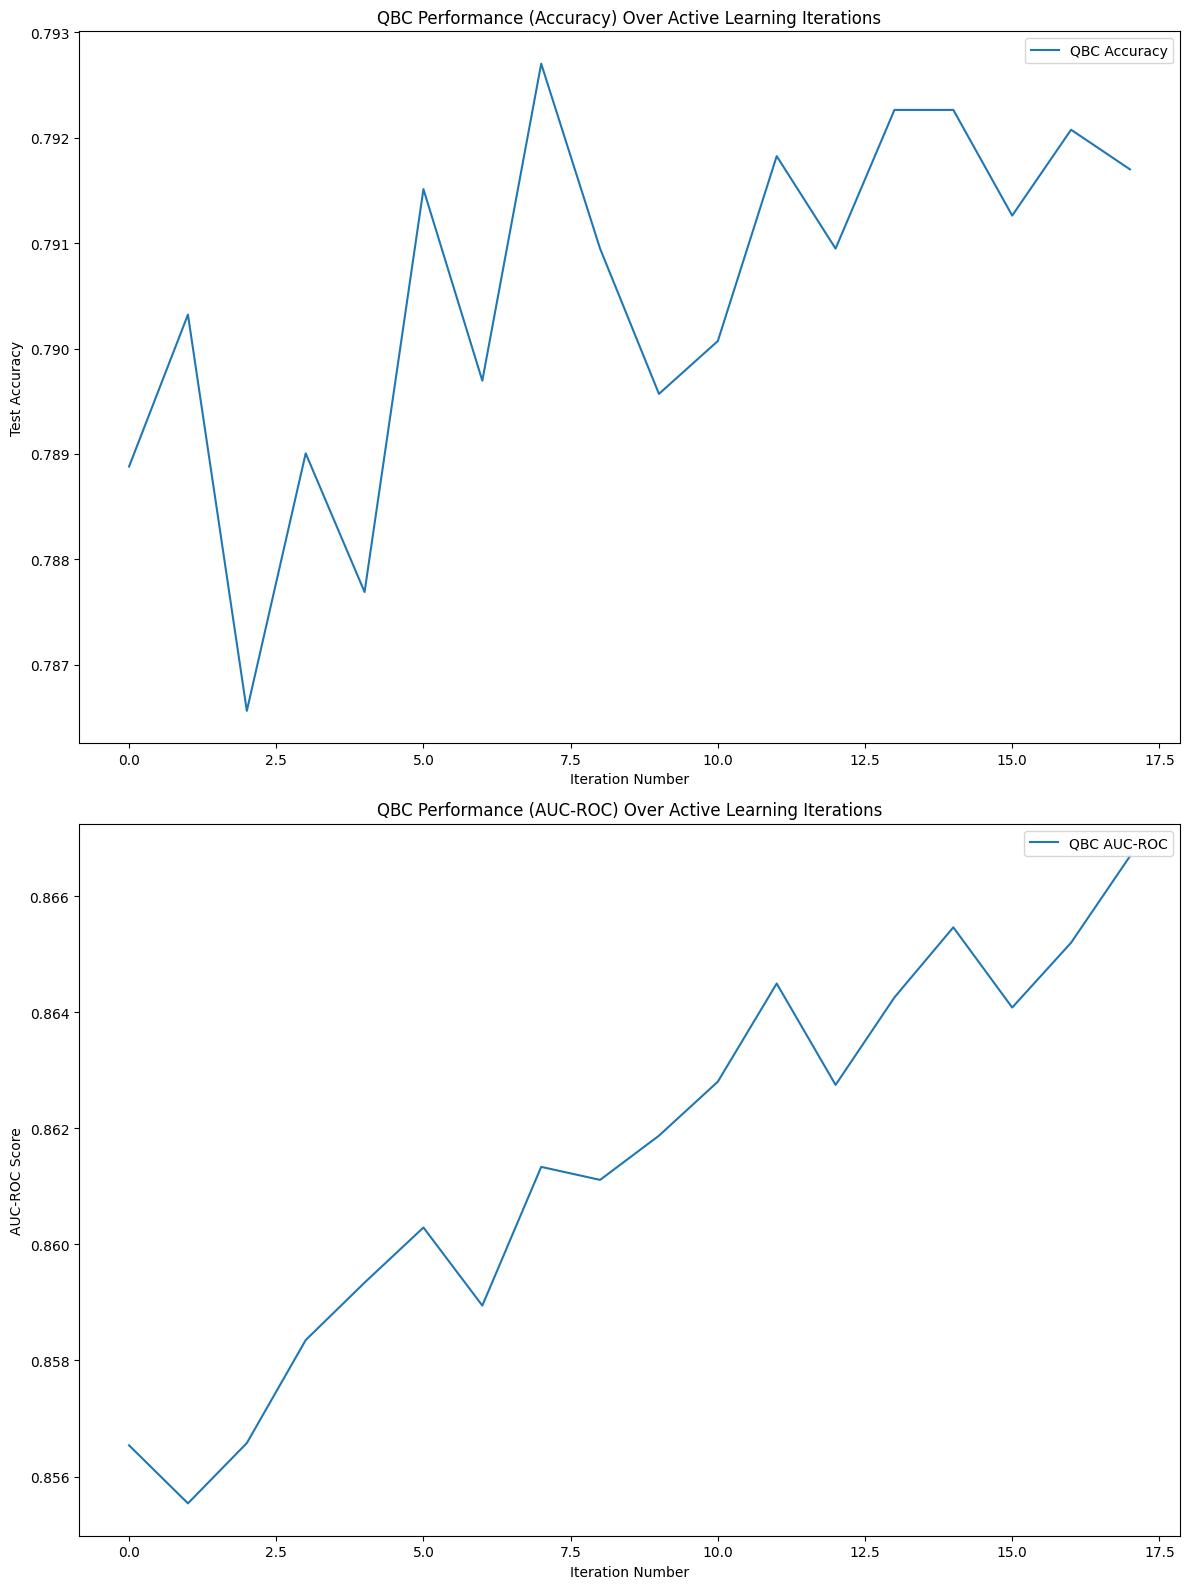

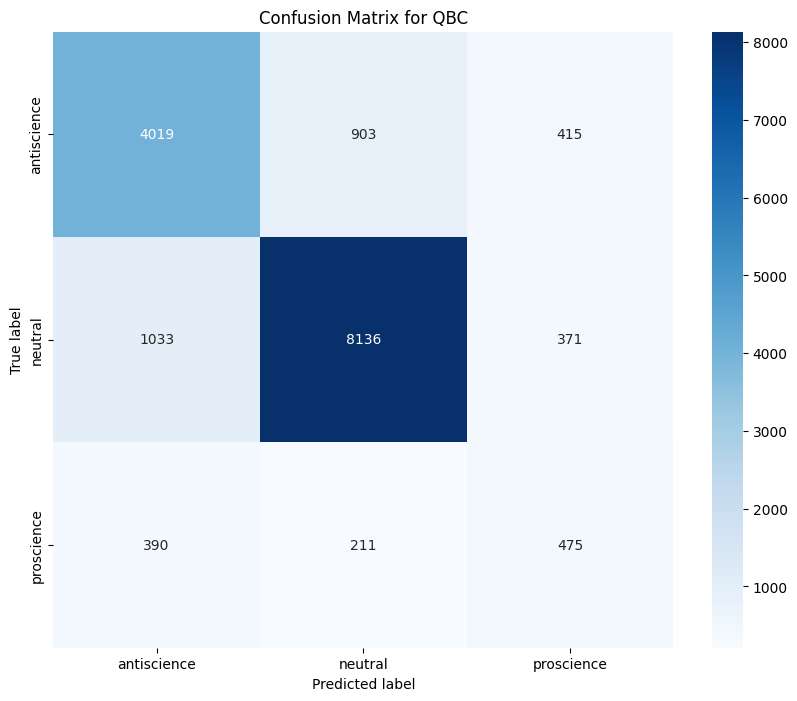

              precision    recall  f1-score   support

 antiscience       0.74      0.75      0.75      5337
     neutral       0.88      0.85      0.87      9540
  proscience       0.38      0.44      0.41      1076

    accuracy                           0.79     15953
   macro avg       0.66      0.68      0.67     15953
weighted avg       0.80      0.79      0.79     15953



In [11]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from modAL.models import Committee, ActiveLearner
from modAL.disagreement import vote_entropy_sampling
from tqdm.notebook import tqdm
import logging
from typing import List, Tuple, Dict
import time
import matplotlib.pyplot as plt
import seaborn as sns

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

class QBCActiveLearningPipeline:
    def __init__(self, main_data_file: str, augmented_data_file: str, embedding_column: str, label_column: str, 
                 test_size: float = 0.2, initial_labeled_ratio: float = 0.3, random_state: int = 42):
        self.main_data_file = main_data_file
        self.augmented_data_file = augmented_data_file
        self.embedding_column = embedding_column
        self.label_column = label_column
        self.test_size = test_size
        self.initial_labeled_ratio = initial_labeled_ratio
        self.random_state = random_state
        self.le = LabelEncoder()
        
        self._log_init_info()
        
    def _log_init_info(self) -> None:
        logger.info("Initializing QBCActiveLearningPipeline")
        logger.info(f"Main data file: {self.main_data_file}")
        logger.info(f"Augmented data file: {self.augmented_data_file}")
        logger.info(f"Embedding column: {self.embedding_column}")
        logger.info(f"Label column: {self.label_column}")
        logger.info(f"Test size: {self.test_size}")
        logger.info(f"Initial labeled ratio: {self.initial_labeled_ratio}")
        logger.info(f"Random state: {self.random_state}")

    def load_and_preprocess_data(self) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        logger.info("Loading and preprocessing data")
        start_time = time.time()
        
        # Load main data
        main_data = self._load_data(self.main_data_file, ' ')
        logger.info(f"Main data shape: {main_data.shape}")
        
        # Load augmented data
        augmented_data = self._load_data(self.augmented_data_file, ',')
        logger.info(f"Augmented data shape: {augmented_data.shape}")
        
        # Encode labels for both datasets
        all_labels = pd.concat([main_data[self.label_column], augmented_data[self.label_column]])
        self.le.fit(all_labels)
        main_data['encoded_label'] = self.le.transform(main_data[self.label_column])
        augmented_data['encoded_label'] = self.le.transform(augmented_data[self.label_column])
        
        # Prepare main data
        X_main = np.stack(main_data[self.embedding_column].values)
        y_main = main_data['encoded_label'].values
        
        # Split main data into train and test
        X_train, X_test, y_train, y_test = train_test_split(X_main, y_main, test_size=self.test_size, 
                                                            random_state=self.random_state, stratify=y_main)
        
        # Prepare augmented data
        X_aug = np.stack(augmented_data[self.embedding_column].values)
        y_aug = augmented_data['encoded_label'].values
        
        # Combine augmented data with training data
        X_train = np.vstack([X_train, X_aug])
        y_train = np.concatenate([y_train, y_aug])
        
        # Split the combined training data into initial labeled set and pool
        X_initial, X_pool, y_initial, y_pool = train_test_split(
            X_train, y_train, train_size=self.initial_labeled_ratio, 
            random_state=self.random_state, stratify=y_train
        )
        
        end_time = time.time()
        logger.info(f"Data loaded and preprocessed in {end_time - start_time:.2f} seconds")
        logger.info(f"Combined training data shape: {X_train.shape}")
        logger.info(f"Test data shape: {X_test.shape}")
        logger.info(f"Initial labeled set shape: {X_initial.shape}")
        logger.info(f"Pool set shape: {X_pool.shape}")
        logger.info(f"Encoded labels: {self.le.classes_}")
        logger.info(f"Class distribution in combined training set: {np.bincount(y_train)}")
        logger.info(f"Class distribution in test set: {np.bincount(y_test)}")
        
        return X_initial, y_initial, X_pool, y_pool, X_test, y_test

    def _load_data(self, file_path: str, separator: str) -> pd.DataFrame:
        chunks = pd.read_csv(file_path, chunksize=10000)
        data_list = []
        for chunk in chunks:
            chunk[self.embedding_column] = chunk[self.embedding_column].apply(lambda x: np.fromstring(x.strip('[]'), sep=separator))
            data_list.append(chunk)
        return pd.concat(data_list)

    def train_with_active_learning(self, X_initial: np.ndarray, y_initial: np.ndarray, 
                                   X_pool: np.ndarray, y_pool: np.ndarray, X_test: np.ndarray, y_test: np.ndarray, 
                                   n_queries: int = 50, n_instances_per_query: int = 500) -> Tuple[str, List[float], List[float], np.ndarray]:
        logger.info("Starting active learning with QBC")
        start_time = time.time()

        # Initialize base models with class weights (except for XGBoost)
        class_weights = {cls: len(y_initial) / (len(self.le.classes_) * np.sum(y_initial == cls)) for cls in range(len(self.le.classes_))}
        
       # lr_model = LogisticRegression(multi_class='ovr', class_weight=class_weights, random_state=self.random_state)
        lgb_model = LGBMClassifier(class_weight=class_weights, random_state=self.random_state)
        cat_model = CatBoostClassifier(
            iterations=1000,
            learning_rate=0.1,
            depth=6,
            loss_function='MultiClass',
            random_seed=self.random_state,
            eval_metric='MultiClass',
            auto_class_weights='Balanced',  # Let CatBoost handle class weights automatically
            verbose=100
        )
        xgb_model = XGBClassifier(
            objective='multi:softprob', 
            num_class=len(self.le.classes_), 
            random_state=self.random_state,
            eval_metric=['mlogloss']
        )

        # Wrap base models in ActiveLearner
       # learner_lr = ActiveLearner(estimator=lr_model, X_training=X_initial, y_training=y_initial)
        learner_lgb = ActiveLearner(estimator=lgb_model, X_training=X_initial, y_training=y_initial)
        learner_cat = ActiveLearner(estimator=cat_model, X_training=X_initial, y_training=y_initial)
        learner_xgb = ActiveLearner(estimator=xgb_model, X_training=X_initial, y_training=y_initial)  
        # Create committee
        committee = Committee(
            learner_list=[learner_lgb, learner_xgb],
            query_strategy=vote_entropy_sampling
        )

        performance_history = []
        auc_history = []
        best_accuracy = 0
        iterations_without_improvement = 0
        max_iterations_without_improvement = 10

        for iteration in tqdm(range(n_queries), desc="Active Learning Progress"):
            query_idx, _ = committee.query(X_pool, n_instances=n_instances_per_query)
            
            committee.teach(X_pool[query_idx], y_pool[query_idx])
            
            X_pool = np.delete(X_pool, query_idx, axis=0)
            y_pool = np.delete(y_pool, query_idx)
            
            y_pred = committee.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            performance_history.append(accuracy)
            
            y_proba = committee.predict_proba(X_test)
            auc_roc = roc_auc_score(y_test, y_proba, multi_class='ovo', average='macro')
            auc_history.append(auc_roc)

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                iterations_without_improvement = 0
                self.best_model = committee
            else:
                iterations_without_improvement += 1

            if (iteration + 1) % 5 == 0:
                logger.info(f"QBC - Iteration {iteration + 1}/{n_queries}: Accuracy = {accuracy:.4f}, AUC-ROC = {auc_roc:.4f}")

            if iterations_without_improvement >= max_iterations_without_improvement:
                logger.info(f"QBC - Early stopping at iteration {iteration + 1} due to no improvement")
                break

        end_time = time.time()
        logger.info(f"QBC - Active learning completed in {end_time - start_time:.2f} seconds")
        logger.info(f"QBC - Final accuracy: {performance_history[-1]:.4f}, Final AUC-ROC: {auc_history[-1]:.4f}")

        y_pred_final = committee.predict(X_test)
        cm = confusion_matrix(y_test, y_pred_final)
        
        return "QBC", performance_history, auc_history, cm

    def run_pipeline(self) -> Tuple[Dict[str, List[float]], Dict[str, List[float]], Dict[str, np.ndarray], str]:
        logger.info("Starting QBC active learning pipeline")
        start_time = time.time()

        X_initial, y_initial, X_pool, y_pool, X_test, y_test = self.load_and_preprocess_data()

        model_name, performance_history, auc_history, cm = self.train_with_active_learning(
            X_initial, y_initial, X_pool, y_pool, X_test, y_test
        )

        self.model_performance = {model_name: performance_history}
        self.model_auc = {model_name: auc_history}
        self.confusion_matrices = {model_name: cm}
        
        end_time = time.time()
        logger.info(f"QBC Active Learning Pipeline completed in {end_time - start_time:.2f} seconds")
        
        logger.info(f"{model_name} - Initial accuracy: {performance_history[0]:.4f}, Final accuracy: {performance_history[-1]:.4f}")
        logger.info(f"{model_name} - Initial AUC-ROC: {auc_history[0]:.4f}, Final AUC-ROC: {auc_history[-1]:.4f}")

        # Generate classification report
        y_pred = self.best_model.predict(X_test)
        class_report = classification_report(y_test, y_pred, target_names=self.le.classes_)
        logger.info("Classification Report:\n" + class_report)

        return self.model_performance, self.model_auc, self.confusion_matrices, class_report

    def plot_results(self) -> None:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 16))
        
        for model_name, accuracies in self.model_performance.items():
            ax1.plot(accuracies, label=f"{model_name} Accuracy")
        ax1.set_title('QBC Performance (Accuracy) Over Active Learning Iterations')
        ax1.set_xlabel('Iteration Number')
        ax1.set_ylabel('Test Accuracy')
        ax1.legend()
        
        for model_name, auc_scores in self.model_auc.items():
            ax2.plot(auc_scores, label=f"{model_name} AUC-ROC")
        ax2.set_title('QBC Performance (AUC-ROC) Over Active Learning Iterations')
        ax2.set_xlabel('Iteration Number')
        ax2.set_ylabel('AUC-ROC Score')
        ax2.legend()
        
        plt.tight_layout()
        plt.show()

    def plot_confusion_matrix(self) -> None:
        for model_name, cm in self.confusion_matrices.items():
            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=self.le.classes_, yticklabels=self.le.classes_)
            plt.title(f'Confusion Matrix for {model_name}')
            plt.ylabel('True label')
            plt.xlabel('Predicted label')
            plt.show()

# Example usage
main_data_file = "sbert_data_with_distance_features.csv"
augmented_data_file = "cleaned_proscience_da.csv"

pipeline = QBCActiveLearningPipeline(
    main_data_file,
    augmented_data_file,
    "dense_embedding",
    "cleaned_classification"
)

results, auc_results, confusion_matrices, class_report = pipeline.run_pipeline()
pipeline.plot_results()
pipeline.plot_confusion_matrix()
print(class_report)

## QBC with xgb and augmented data + ipw enhanced 

In [3]:
import pandas as pd
import numpy as np
import faiss
import time
import logging
from typing import List, Tuple, Dict
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, normalize
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from modAL.models import Committee, ActiveLearner
from modAL.uncertainty import entropy_sampling
from modAL.disagreement import vote_entropy_sampling

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

class OptimizedQBCActiveLearningPipeline:
    def __init__(self, main_data_file: str, augmented_data_file: str, embedding_column: str, label_column: str, 
                 test_size: float = 0.2, initial_labeled_ratio: float = 0.3, random_state: int = 42):
        self.temperature = 1.0
        self.main_data_file = main_data_file
        self.augmented_data_file = augmented_data_file
        self.embedding_column = embedding_column
        self.label_column = label_column
        self.test_size = test_size
        self.initial_labeled_ratio = initial_labeled_ratio
        self.random_state = random_state
        self.le = LabelEncoder()
        self.faiss_index = None
        
        self._log_init_info()

    def _log_init_info(self) -> None:
        logger.info("Initializing OptimizedQBCActiveLearningPipeline")
        logger.info(f"Main data file: {self.main_data_file}")
        logger.info(f"Augmented data file: {self.augmented_data_file}")
        logger.info(f"Embedding column: {self.embedding_column}")
        logger.info(f"Label column: {self.label_column}")
        logger.info(f"Test size: {self.test_size}")
        logger.info(f"Initial labeled ratio: {self.initial_labeled_ratio}")
        logger.info(f"Random state: {self.random_state}")

    def _load_data(self, file_path: str, separator: str) -> pd.DataFrame:
        logger.info(f"Loading data from {file_path}")
        chunks = pd.read_csv(file_path, chunksize=10000)
        data_list = []
        for chunk in chunks:
            chunk[self.embedding_column] = chunk[self.embedding_column].apply(lambda x: np.fromstring(x.strip('[]'), sep=separator))
            data_list.append(chunk)
        return pd.concat(data_list)

    def load_and_preprocess_data(self) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        logger.info("Loading and preprocessing data")
        start_time = time.time()
        
        main_data = self._load_data(self.main_data_file, ' ')
        augmented_data = self._load_data(self.augmented_data_file, ',')
        
        all_labels = pd.concat([main_data[self.label_column], augmented_data[self.label_column]])
        self.le.fit(all_labels)
        main_data['encoded_label'] = self.le.transform(main_data[self.label_column])
        augmented_data['encoded_label'] = self.le.transform(augmented_data[self.label_column])
        
        X_main = np.stack(main_data[self.embedding_column].values)
        y_main = main_data['encoded_label'].values
        
        X_train, X_test, y_train, y_test = train_test_split(X_main, y_main, test_size=self.test_size, 
                                                            random_state=self.random_state, stratify=y_main)
        
        X_aug = np.stack(augmented_data[self.embedding_column].values)
        y_aug = augmented_data['encoded_label'].values
        
        X_train = np.vstack([X_train, X_aug])
        y_train = np.concatenate([y_train, y_aug])
        
        X_initial, X_pool, y_initial, y_pool = train_test_split(
            X_train, y_train, train_size=self.initial_labeled_ratio, 
            random_state=self.random_state, stratify=y_train
        )
        
        end_time = time.time()
        logger.info(f"Data loaded and preprocessed in {end_time - start_time:.2f} seconds")
        logger.info(f"Combined training data shape: {X_train.shape}")
        logger.info(f"Test data shape: {X_test.shape}")
        logger.info(f"Initial labeled set shape: {X_initial.shape}")
        logger.info(f"Pool set shape: {X_pool.shape}")
        
        return X_initial, y_initial, X_pool, y_pool, X_test, y_test

    def initialize_faiss_index(self, X: np.ndarray) -> None:
        X_normalized = normalize(X)
        d = X_normalized.shape[1]
        self.faiss_index = faiss.IndexFlatIP(d)
        self.faiss_index.add(X_normalized.astype('float32'))

    def calculate_ipw(self, y: np.ndarray) -> np.ndarray:
        class_counts = np.bincount(y)
        total_samples = len(y)
        class_weights = (total_samples / (len(class_counts) * class_counts)) ** (1 / self.temperature)
        return np.array([class_weights[c] for c in y])

    def diversity_score_faiss(self, X: np.ndarray, selected_indices: np.ndarray, k: int = 5) -> np.ndarray:
        if len(selected_indices) == 0:
            return np.ones(len(X))
        
        X_normalized = normalize(X)
        _, I = self.faiss_index.search(X_normalized.astype('float32'), k)
        diversity_scores = np.mean(1 - I[:, :k], axis=1)
        
        return diversity_scores

    
        
    def advanced_query_strategy(self, classifier: Committee, X: np.ndarray, n_instances: int = 1) -> Tuple[np.ndarray, np.ndarray]:
        disagreement = vote_entropy_sampling(classifier, X)[0]
        uncertainty = entropy_sampling(classifier, X)[0]
        
        # Get all labeled data
        labeled_data = [learner.X_training for learner in classifier.learner_list]
        labeled_y = [learner.y_training for learner in classifier.learner_list]
        
        # Concatenate all labeled data
        all_labeled_data = np.concatenate(labeled_data, axis=0)
        all_labeled_y = np.concatenate(labeled_y, axis=0)
        
        ipw = self.calculate_ipw(all_labeled_y)
        mean_ipw = np.mean(ipw)
        
        diversity = self.diversity_score_faiss(X, all_labeled_data)
        
        # Log or print raw scores for debugging purposes
        logger.info(f"Uncertainty scores before normalization: {uncertainty}")
        logger.info(f"Diversity scores before normalization: {diversity}")
        
        # Normalize scores
        uncertainty_normalized = self.normalize_scores(uncertainty, "Uncertainty")
        diversity_normalized = self.normalize_scores(diversity, "Diversity")
        
        # Compute Pareto-front-style combination by ranking both
        combined_ranks = np.argsort(uncertainty_normalized) + np.argsort(diversity_normalized)
        selected_indices = np.argsort(combined_ranks)[-n_instances:]
        
        return selected_indices, combined_ranks[selected_indices]

    def normalize_scores(self, scores: np.ndarray, score_type: str) -> np.ndarray:
        min_val = scores.min()
        max_val = scores.max()
        
        # Log min and max values for each score
        logger.info(f"{score_type} scores - min: {min_val}, max: {max_val}")
        
        # If all values are the same, avoid division by zero by returning an array of zeros
        if max_val == min_val:
            logger.warning(f"All {score_type} scores are the same. Returning zeros.")
            return np.zeros_like(scores)
        
        normalized_scores = (scores - min_val) / (max_val - min_val)
        
        # Log normalized scores for debugging
        logger.info(f"Normalized {score_type} scores: {normalized_scores}")
        
        return normalized_scores

    def adaptive_query_size(self, current_iteration: int, max_iterations: int, min_instances: int, max_instances: int) -> int:
        progress = current_iteration / max_iterations
        return int(min_instances + (max_instances - min_instances) * (1 - progress))

    def train_with_active_learning(self, X_initial: np.ndarray, y_initial: np.ndarray, 
                                   X_pool: np.ndarray, y_pool: np.ndarray, X_test: np.ndarray, y_test: np.ndarray, 
                                   n_queries: int = 50, max_instances_per_query: int = 500) -> Tuple[str, List[float], List[float], np.ndarray]:
        logger.info("Starting optimized active learning with QBC and FAISS")
        start_time = time.time()

        self.initialize_faiss_index(np.vstack([X_initial, X_pool, X_test]))
        
        # Initialize base models with class weights (except for XGBoost)
        class_weights = {cls: len(y_initial) / (len(self.le.classes_) * np.sum(y_initial == cls)) for cls in range(len(self.le.classes_))}

        lr_model = LogisticRegression(multi_class='ovr', class_weight=class_weights, random_state=self.random_state)
        lgb_model = LGBMClassifier(class_weight=class_weights, random_state=self.random_state)
        gnb_model = GaussianNB()
        xgb_model = XGBClassifier(
            objective='multi:softprob', 
            num_class=len(self.le.classes_), 
            random_state=self.random_state,
            eval_metric='mlogloss'
        )

        learner_lr = ActiveLearner(estimator=lr_model, X_training=X_initial, y_training=y_initial)
        learner_lgb = ActiveLearner(estimator=lgb_model, X_training=X_initial, y_training=y_initial)
        learner_gnb = ActiveLearner(estimator=gnb_model, X_training=X_initial, y_training=y_initial)
        learner_xgb = ActiveLearner(estimator=xgb_model, X_training=X_initial, y_training=y_initial)

        committee = Committee(
            learner_list=[learner_lr, learner_lgb, learner_gnb, learner_xgb],
            query_strategy=self.advanced_query_strategy
        )

        performance_history = []
        auc_history = []
        best_accuracy = 0
        iterations_without_improvement = 0
        max_iterations_without_improvement = 10

        for iteration in tqdm(range(n_queries), desc="Optimized Active Learning Progress"):
            # Adaptive query size
            n_instances = self.adaptive_query_size(iteration, n_queries, 10, max_instances_per_query)
            
            query_idx, _ = committee.query(X_pool, n_instances=n_instances)
            
            committee.teach(X_pool[query_idx], y_pool[query_idx])
            
            self.faiss_index.remove_ids(np.arange(len(X_pool))[query_idx])
            
            X_pool = np.delete(X_pool, query_idx, axis=0)
            y_pool = np.delete(y_pool, query_idx)
            
            y_pred = committee.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            performance_history.append(accuracy)
            
            y_proba = committee.predict_proba(X_test)
            auc_roc = roc_auc_score(y_test, y_proba, multi_class='ovo', average='macro')
            auc_history.append(auc_roc)

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                iterations_without_improvement = 0
                self.best_model = committee
            else:
                iterations_without_improvement += 1

            self.temperature = max(0.5, self.temperature * 0.99)

            if (iteration + 1) % 5 == 0:
                logger.info(f"Optimized QBC - Iteration {iteration + 1}/{n_queries}: Accuracy = {accuracy:.4f}, AUC-ROC = {auc_roc:.4f}")

            if iterations_without_improvement >= max_iterations_without_improvement:
                logger.info(f"Optimized QBC - Early stopping at iteration {iteration + 1} due to no improvement")
                break

        end_time = time.time()
        logger.info(f"Optimized QBC - Active learning completed in {end_time - start_time:.2f} seconds")
        logger.info(f"Optimized QBC - Final accuracy: {performance_history[-1]:.4f}, Final AUC-ROC: {auc_history[-1]:.4f}")

        y_pred_final = committee.predict(X_test)
        cm = confusion_matrix(y_test, y_pred_final)
        
        return "Optimized QBC", performance_history, auc_history, cm

    def run_pipeline(self) -> Tuple[Dict[str, List[float]], Dict[str, List[float]], Dict[str, np.ndarray], str]:
        logger.info("Starting Optimized QBC active learning pipeline")
        start_time = time.time()

        X_initial, y_initial, X_pool, y_pool, X_test, y_test = self.load_and_preprocess_data()

        model_name, performance_history, auc_history, cm = self.train_with_active_learning(
            X_initial, y_initial, X_pool, y_pool, X_test, y_test
        )

        self.model_performance = {model_name: performance_history}
        self.model_auc = {model_name: auc_history}
        self.confusion_matrices = {model_name: cm}
        
        end_time = time.time()
        logger.info(f"Optimized QBC Active Learning Pipeline completed in {end_time - start_time:.2f} seconds")
        
        logger.info(f"{model_name} - Initial accuracy: {performance_history[0]:.4f}, Final accuracy: {performance_history[-1]:.4f}")
        logger.info(f"{model_name} - Initial AUC-ROC: {auc_history[0]:.4f}, Final AUC-ROC: {auc_history[-1]:.4f}")

        y_pred = self.best_model.predict(X_test)
        class_report = classification_report(y_test, y_pred, target_names=self.le.classes_)
        logger.info("Classification Report:\n" + class_report)

        return self.model_performance, self.model_auc, self.confusion_matrices, class_report

    def plot_results(self) -> None:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 16))
        
        for model_name, accuracies in self.model_performance.items():
            ax1.plot(accuracies, label=f"{model_name} Accuracy")
        ax1.set_title('QBC Performance (Accuracy) Over Active Learning Iterations')
        ax1.set_xlabel('Iteration Number')
        ax1.set_ylabel('Test Accuracy')
        ax1.legend()
        
        for model_name, auc_scores in self.model_auc.items():
            ax2.plot(auc_scores, label=f"{model_name} AUC-ROC")
        ax2.set_title('QBC Performance (AUC-ROC) Over Active Learning Iterations')
        ax2.set_xlabel('Iteration Number')
        ax2.set_ylabel('AUC-ROC Score')
        ax2.legend()
        
        plt.tight_layout()
        plt.show()

    def plot_confusion_matrix(self) -> None:
        for model_name, cm in self.confusion_matrices.items():
            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=self.le.classes_, yticklabels=self.le.classes_)
            plt.title(f'Confusion Matrix for {model_name}')
            plt.ylabel('True label')
            plt.xlabel('Predicted label')
            plt.tight_layout()
            plt.show()
            

# Run pipeline
pipeline = OptimizedQBCActiveLearningPipeline('sbert_llama_classifications.csv', 'cleaned_proscience_da.csv', "dense_embedding", "cleaned_classification")
results, auc_results, confusion_matrices, class_report = pipeline.run_pipeline()
pipeline.plot_results()
pipeline.plot_confusion_matrix()
print(class_report)

2024-09-24 14:38:31,433 - INFO - Initializing OptimizedQBCActiveLearningPipeline
2024-09-24 14:38:31,433 - INFO - Main data file: sbert_llama_classifications.csv
2024-09-24 14:38:31,434 - INFO - Augmented data file: cleaned_proscience_da.csv
2024-09-24 14:38:31,434 - INFO - Embedding column: dense_embedding
2024-09-24 14:38:31,434 - INFO - Label column: cleaned_classification
2024-09-24 14:38:31,435 - INFO - Test size: 0.2
2024-09-24 14:38:31,435 - INFO - Initial labeled ratio: 0.3
2024-09-24 14:38:31,436 - INFO - Random state: 42
2024-09-24 14:38:31,436 - INFO - Starting Optimized QBC active learning pipeline
2024-09-24 14:38:31,436 - INFO - Loading and preprocessing data
2024-09-24 14:38:31,437 - INFO - Loading data from sbert_llama_classifications.csv
2024-09-24 14:38:42,069 - INFO - Loading data from cleaned_proscience_da.csv
2024-09-24 14:38:43,569 - INFO - Data loaded and preprocessed in 12.13 seconds
2024-09-24 14:38:43,570 - INFO - Combined training data shape: (69188, 384)
202